# GNN applications: Genes and Pathway embeddings

There are two datasets available and 2 types of one dataset, that is:
* The graph metapathways **metapathway_kegg_genes/gene_edges.tsv**
* The list of nodes for a pathway **metapathway_kegg_genes/pathways.tsv**
* The expression matrices normalized for:
  * Controls patients **locicero_brca_normalizzato\locicero_brca_data_norm_2.txt**
  * Tumor patients **locicero_brca_tumor\locicero_brca_data_tumor_zscores.txt**

Both of the patients are normalized with a z-score method, there is also another normalization but better results are expected with z-scores.

In [1]:
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from stellargraph.mapper import DirectedGraphSAGENodeGenerator
from stellargraph.layer import DirectedGraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model,Input

import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import math
from sklearn import preprocessing,model_selection

from collections import defaultdict

from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.python.ops.numpy_ops import np_config
#np_config.enable_numpy_behavior()

The library used are **stellargraph** for using the GNN methods, and **tensorflow** to train the models and find the best parameters for the objective function defined in the documentation.

In [2]:
def load_my_data():
    #controlsDK = pd.read_csv('controls_counts.tsv', sep='\t', header=0).dropna()
    #z_score normalized data, the other espression matrices are normalized with another method
    controlsDK = pd.read_csv('locicero_brca_normalizzato/locicero_brca_data_norm_2.tsv', sep='\t', header=0).dropna()
    controlsDK.index = controlsDK.index.astype(int)
    controlsDK = controlsDK.sort_index()
    tumorDK = pd.read_csv('locicero_brca_tumor/locicero_brca_data_tumor_zscores.txt', sep='\t', header=0).dropna()
    tumorDK.index = tumorDK.index.astype(int)
    tumorDK = tumorDK.sort_index()
    tmp = pd.read_csv('metapathway_kegg_genes/gene_edges.tsv', sep='\t', header=0)
    # creating adjacency list
    def add_edges(currentDict,N,M):
        N_set = set()
        if str(N) in currentDict:
            N_set = currentDict[str(N)]
        N_set.add(str(M))
        currentDict[str(N)] = N_set
    
    outAdjacencyListMetapathways = defaultdict(set)
    inAdjacencyListMetapathways = defaultdict(set)
    for index, row in tmp.iterrows():
        add_edges(outAdjacencyListMetapathways,row["start"],row["end"])
        add_edges(inAdjacencyListMetapathways,row["end"],row["start"])
        
    # controls with features
    boolGenesWithFeatureSources = tmp["start"].map(lambda value: value in controlsDK.index)
    boolGenesWithFeatureTargets = tmp["end"].map(lambda value: value in controlsDK.index)
    boolGenesWithFeature = boolGenesWithFeatureSources & boolGenesWithFeatureTargets

    # tumors with features
    boolGenesTumorWithFeatureSources = tmp["start"].map(lambda value: value in tumorDK.index)
    boolGenesTumorWithFeatureTargets = tmp["end"].map(lambda value: value in tumorDK.index)
    boolGenesTumorWithFeature = boolGenesTumorWithFeatureSources & boolGenesTumorWithFeatureTargets

    #genesWithNoFeatures = [100653049, 9103, 2831, 100528032, 100132285, 3810, 3806, 3808,390441, 3118, 3126, 3125, 390271, 26595, 81399, 432355, 100996746, 504190, 504191, 140, 504189, 729759, 100532736,107080638, 414062, 102723407, 6019, 3803, 107181291, 102723555, 102723532, 107987545, 102800317, 100505767, 341568, 112268384, 100533105, 106821730, 388372, 105369274, 100271849, 57292, 390432]
    tmpGeneEdges = pd.read_csv('metapathway_kegg_genes/gene_edges.tsv', sep='\t', header=0).rename(columns={'start': 'source', 'end': 'target'}) 
    #geneEdgesWithNoFeatures = pd.concat(
    #    [geneEdgesWithNoFeatures[geneEdgesWithNoFeatures['source'].isin(genesWithNoFeatures)], 
    #     geneEdgesWithNoFeatures[geneEdgesWithNoFeatures['target'].isin(genesWithNoFeatures)]]
    #     )
    #geneEdgesWithNoFeatures = geneEdgesWithNoFeatures.drop_duplicates()
    geneEdgesWithNoFeatures = tmpGeneEdges[~boolGenesWithFeature]
    geneEdgesWithNoFeaturesTumor = tmpGeneEdges[~boolGenesTumorWithFeature]

    # indexes of control genes with features and not
    indexesGenesWithFeatures = controlsDK.index
    indexesGenesWithNoFeatures = pd.concat([ geneEdgesWithNoFeatures[~geneEdgesWithNoFeatures["source"].isin(controlsDK.index)]["source"] , geneEdgesWithNoFeatures[~geneEdgesWithNoFeatures["target"].isin(controlsDK.index)]["target"] ]).drop_duplicates()


    # indexes of tumor genes with features and not
    indexesGenesTumorWithFeatures = tumorDK.index
    indexesGenesTumorWithNoFeatures = pd.concat([ geneEdgesWithNoFeaturesTumor[~geneEdgesWithNoFeaturesTumor["source"].isin(tumorDK.index)]["source"] , geneEdgesWithNoFeaturesTumor[~geneEdgesWithNoFeaturesTumor["target"].isin(tumorDK.index)]["target"] ]).drop_duplicates()

    #filtering genes with no features
    #geneEdges = geneEdges[~geneEdges['source'].isin(genesWithNoFeatures)]
    #geneEdges = geneEdges[~geneEdges['target'].isin(genesWithNoFeatures)]
    geneEdges = tmpGeneEdges[boolGenesWithFeature]
    geneEdgesTumor = tmpGeneEdges[boolGenesTumorWithFeature]
    pathways = pd.read_csv('metapathway_kegg_genes/pathways.tsv', sep='\t', header=0)
    return inAdjacencyListMetapathways,outAdjacencyListMetapathways,controlsDK,tumorDK, geneEdges,geneEdgesTumor,geneEdgesWithNoFeatures,geneEdgesWithNoFeaturesTumor,indexesGenesWithFeatures,indexesGenesWithNoFeatures,indexesGenesTumorWithFeatures,indexesGenesTumorWithNoFeatures, pathways

# TODO
Taking into account genes with no features in the expression matrices(the one dropped because some values were NA), I have divided them for the two datasets of patients, but an hybrid approach could be better if we use the same model, because I have in mind to use two different models for controls and tumor, but a better approach could be to take the full expression matrix(or the union of the expressed genes with features) and complete the genes that have been dropped(that is by controlling the specific values before dropping the NA, or **substituting the NA with some value** (that could be 0, a random value taken from the distribution of the defined gene expression for the row, the expression distribution that is)). 

When sampling the tumor expressions dataset, the dropped rows in the load step should be done only on the selected columns since some of them were dropped, additionally we could totally drop columns and not rows where the values are N.A.

In [3]:
inAdjacencyListMetapathways,outAdjacencyListMetapathways,controlsDK,tumorDK,geneEdges,geneEdgesTumor,geneEdgesWithNoFeatures,geneEdgesWithNoFeaturesTumor,indexGeneEdgesWithFeatures,indexGeneEdgesWithNoFeatures,indexesGenesTumorWithFeatures,indexesGenesTumorWithNoFeatures,pathways = load_my_data()

This variables are the following:
- inAdjacencyListMetapathways is used to remember all the predecessor edges(incoming) for the nodes
- inAdjacencyListMetapathways is used to remember all the antecedent edges(outgoing) for the nodes
- controlsDK is the expression matrix for the controls patients
- tumorDK is the expression matrix for the tumor patients
- geneEdges are the edges in the graph for the controls patients(subgraph with only the genes that are present in controls)
- geneEdgesTumor are the edges in the graph for the tumor patients(subgraph with only the genes that are present in tumors)
- geneEdgesWithNoFeatures are the edges in the graph that have no features for the controls patients(subgraph with only the genes that are not present in controls)
- geneEdgesWithNoFeaturesTumor are the edges in the graph that have no features for the tumor patients(subgraph with only the genes that are not present in tumors)
- indexGeneEdgesWithFeatures row number for genes in controls with features
- indexGeneEdgesWithNoFeatures row number for genes in controls with NA features
- indexesGenesTumorWithFeatures ""
- indexesGenesTumorWithNoFeatures ""
- **pathways** are the  

In [4]:
tumorDKwithAnnotation = tumorDK.copy()
tumorDK = tumorDK.drop(["Hugo_Symbol","Entrez_Gene_Id"],axis=1)

**sampling columns because there are too many features and GPU memory is not enouth, probably leaving aside this in the future.** 

In [5]:
tumorDKfull = tumorDK.copy()
tumorDK = tumorDK.sample(frac=0.36, axis='columns', random_state=2)

In [6]:
tumorDK.head()

,TCGA-A2-A1FX-01,TCGA-D8-A1XB-01,TCGA-BH-A0E1-01,TCGA-AQ-A04J-01,TCGA-BH-A0E9-01,TCGA-C8-A133-01,TCGA-B6-A0IG-01,TCGA-LL-A8F5-01,TCGA-E2-A14Q-01,TCGA-AR-A2LQ-01,...,TCGA-A2-A0YI-01,TCGA-A2-A4S1-01,TCGA-A8-A07B-01,TCGA-AC-A5XS-01,TCGA-GM-A5PV-01,TCGA-A1-A0SI-01,TCGA-AC-A2BK-01,TCGA-OL-A5DA-01,TCGA-AR-A254-01,TCGA-B6-A0I9-01
2,-0.5772,0.0209,-0.7586,2.1600,1.1307,-3.1855,0.5628,-0.3130,0.2152,0.3056,...,0.8890,-1.4533,2.8468,1.1668,0.6725,-0.7789,1.3228,0.5238,1.4049,1.7294
3,2.6653,0.6561,1.1721,4.9628,-0.0738,-1.3790,2.4804,0.9024,0.7318,-0.2345,...,-2.9581,-3.1707,3.2360,2.7485,3.1355,-1.6424,4.9777,2.2812,1.2282,2.0500
7,-2.1170,-2.1170,-2.1170,-1.2330,-0.4007,-2.1170,-0.5807,-2.1170,-2.1170,-2.1170,...,0.8095,-2.1170,-2.1170,-2.1170,-2.1170,-1.2897,-2.1170,-0.1780,-0.6475,-2.1170
8,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,21.3320,-4.3428,-4.3428,...,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428
10,-1.9741,-1.9741,-1.9741,-1.0737,-1.9741,-1.9741,-1.9741,-1.9741,-1.9741,-1.9741,...,-1.9741,7.1459,-1.9741,3.6795,-0.8834,-1.1315,-1.9741,0.6688,-1.1408,-1.0705


In [7]:
tumorDKwithAnnotation.head()

,Hugo_Symbol,Entrez_Gene_Id,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
2,UBE2Q2P2,100134869,1.4054,1.8883,0.8671,1.1569,1.5834,1.4882,0.8268,1.5793,...,1.5769,1.1282,-0.7352,1.5768,0.2812,-0.6605,2.2363,2.6390,0.5014,2.4780
3,HMGB1P1,10357,-2.6318,-1.1750,2.8280,2.4738,-0.2282,1.3096,1.0050,1.4029,...,2.1756,2.1944,-5.3776,1.8957,-2.4922,-3.6798,2.2552,-1.5958,-0.1787,3.2450
7,RNU12-2P,26823,-2.1170,0.2431,-2.1170,-1.0068,-0.9801,-2.1170,-0.7680,-0.9244,...,-2.1170,-2.1170,-0.5783,-0.8715,-2.1170,3.0903,2.1266,-0.8763,-0.6152,-1.1594
8,SSX9P,280660,-4.3428,-0.2931,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,...,1.1306,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428
10,EZHIP,340602,1.2983,14.2840,-1.9741,-1.9741,-0.8161,-1.9741,-1.9741,0.1242,...,-1.9741,8.4276,-1.9741,0.2060,3.7291,-0.0279,2.3484,7.5525,-1.9741,-0.9987


In [8]:
geneEdgesWithNoFeatures.head()

,source,target,weight
0,3640,51289,1
1,3640,122042,1
2,3640,339403,1
30,121275,2788,1
31,121275,2774,1


In [8]:
geneEdgesWithNoFeaturesTumor.head()

,source,target,weight
0,3640,51289,1
1,3640,122042,1
2,3640,339403,1
3,3640,59350,1
4,284217,3680,1


In [9]:
geneEdgesWithNoFeatures.count()

source    8963
target    8963
weight    8963
dtype: int64

In [10]:
geneEdgesWithNoFeaturesTumor.count()

source    11646
target    11646
weight    11646
dtype: int64

In [11]:
geneEdges.count()

source    19947
target    19947
weight    19947
dtype: int64

In [12]:
geneEdgesTumor.count()

source    17264
target    17264
weight    17264
dtype: int64

In [13]:
controlsDK.head()

,TCGA-E2-A1L7-11A-33R-A144-07,TCGA-BH-A0BC-11A-22R-A089-07,TCGA-E9-A1N9-11A-71R-A14D-07,TCGA-BH-A18P-11A-43R-A12D-07,TCGA-BH-A1FB-11A-33R-A13Q-07,TCGA-E9-A1RB-11A-33R-A157-07,TCGA-BH-A1EO-11A-31R-A137-07,TCGA-GI-A2C8-11A-22R-A16F-07,TCGA-E9-A1NA-11A-33R-A144-07,TCGA-BH-A0H9-11A-22R-A466-07,...,TCGA-BH-A0B5-11A-23R-A12P-07,TCGA-BH-A1F8-11B-21R-A13Q-07,TCGA-A7-A0CH-11A-32R-A089-07,TCGA-BH-A1FM-11B-23R-A13Q-07,TCGA-BH-A18K-11A-13R-A12D-07,TCGA-E9-A1NF-11A-73R-A14D-07,TCGA-BH-A18U-11A-23R-A12D-07,TCGA-BH-A208-11A-51R-A157-07,TCGA-BH-A1EW-11B-33R-A137-07,TCGA-BH-A204-11A-53R-A157-07
1,2.439591,1.004656,1.599506,1.239184,2.378383,0.943205,1.152047,-0.639025,1.853060,2.006845,...,-0.991596,1.574434,2.381900,1.606963,1.776588,0.497882,1.806789,1.720538,1.908005,0.623442
2,11.117521,10.700190,9.912663,10.474133,10.027498,10.540336,11.246892,10.206510,10.568919,11.340917,...,10.605164,10.596202,10.600770,10.643696,10.941248,10.856412,10.177214,9.934674,9.725920,11.157303
9,2.615676,2.953189,1.625789,2.475094,3.611098,4.456799,2.610675,0.141662,4.567000,1.842379,...,2.162604,2.803166,6.262478,2.162206,2.174944,1.894063,4.200827,1.692294,7.640509,2.870837
10,-3.253567,-2.009078,2.278639,-4.987067,-1.441223,-3.628251,-3.850246,-5.924427,-2.509816,-3.570403,...,-2.648709,-2.123392,0.647096,-2.375228,-3.034509,-4.754595,-0.293221,-4.750650,-1.192199,-2.146698
12,9.974828,9.649463,7.164353,6.765174,8.275051,8.173861,4.038497,2.539097,9.262608,4.256145,...,2.984007,8.878554,8.679858,7.475653,8.017009,2.971056,9.331412,8.747028,8.771013,7.260385


In [14]:
tumorDK.head()

,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
2,1.4054,1.8883,0.8671,1.1569,1.5834,1.4882,0.8268,1.5793,1.1918,-0.2327,...,1.5769,1.1282,-0.7352,1.5768,0.2812,-0.6605,2.2363,2.6390,0.5014,2.4780
3,-2.6318,-1.1750,2.8280,2.4738,-0.2282,1.3096,1.0050,1.4029,-1.9085,2.7901,...,2.1756,2.1944,-5.3776,1.8957,-2.4922,-3.6798,2.2552,-1.5958,-0.1787,3.2450
7,-2.1170,0.2431,-2.1170,-1.0068,-0.9801,-2.1170,-0.7680,-0.9244,-1.2006,-2.1170,...,-2.1170,-2.1170,-0.5783,-0.8715,-2.1170,3.0903,2.1266,-0.8763,-0.6152,-1.1594
8,-4.3428,-0.2931,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,...,1.1306,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428,-4.3428
10,1.2983,14.2840,-1.9741,-1.9741,-0.8161,-1.9741,-1.9741,0.1242,-0.3155,-1.9741,...,-1.9741,8.4276,-1.9741,0.2060,3.7291,-0.0279,2.3484,7.5525,-1.9741,-0.9987


<AxesSubplot:ylabel='Density'>

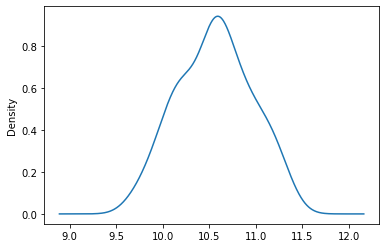

In [15]:
controlsDK.iloc[1].plot.kde()

In [16]:
pathways.head()

,pathway_id,pathway_name,nodes
0,path:hsa00190,Oxidative phosphorylation,64077;5464;245972;245973;479;513;514;515;516;5...
1,path:hsa00072,Synthesis and degradation of ketone bodies,64064;38;39;3155;56898;54511;622;3158;3157;5019
2,path:hsa01040,Biosynthesis of unsaturated fatty acids,641371;79966;6319;570;9415;3992;10965;122970;1...
3,path:hsa04672,Intestinal immune network for IgA production,4055;8174;959;8741;3600;23308;102723407;6370;5...
4,path:hsa03460,Fanconi anemia pathway,3280;378708;55120;672;84126;675;2189;83990;229...


# Preliminary definitions

In [6]:
@tf.function
def difference_of_edge_genes_embeddingGCN(edges,y_pred):
    #gene1 = tf.gather(y_pred,edges[0])
    #gene2 = tf.gather(y_pred,edges[1])
    gene1 = y_pred[0][edges[0]]
    gene2 = y_pred[0][edges[1]]
    return tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)

tfControls = tf.constant(controlsDK,tf.float32)
#difference_of_edge_genes_embedding(tensorEdgesTest[3],tfControls)

In [7]:
## TESTING the computation of c
def testC(gene1,gene2,inList,outList):
    source1AdjSet = outList[str(gene1)]
    source2AdjSet = outList[str(gene2)]
    source1PredSet = inList[str(gene1)]
    source2PredSet = inList[str(gene2)]
    #c = (len(source1AdjSet) + len(source1PredSet) + len(source2AdjSet) + len(source2PredSet) -
    #     (len(source1AdjSet.union(source2AdjSet)) + len(source1PredSet.union(source2PredSet) ))) 
    c = ( (len(source1AdjSet.union(source2AdjSet)) + len(source1PredSet.union(source2PredSet) )) + 
         abs(len(source1AdjSet)-len(source2AdjSet)) + abs(len(source1PredSet)-len(source2PredSet)) )
    return c
testC(3640,6013,inAdjacencyListMetapathways,outAdjacencyListMetapathways)

4

In [8]:
def precomputeCostantsTensor(tensorEdges,inAdjacencyListMetapathways,outAdjacencyListMetapathways,divider):
    constantsList = []
    for i in range(0,tensorEdges.shape[0]):
        c = testC(tensorEdges[i][0].numpy(),
                tensorEdges[i][1].numpy(),inAdjacencyListMetapathways,outAdjacencyListMetapathways) / divider
        constantsList.append(c)
    return constantsList,tf.constant(constantsList,tf.float32)

In [9]:

@tf.function( experimental_relax_shapes=True)
def difference_of_genes_embedding_weightedGCN(node1,node2,y_pred,c):
    # dividing by max degree to get a small value could be a better option
    gene1 = y_pred[0][node1]
    gene2 = y_pred[0][node2]
    return c*tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)


@tf.function
def difference_of_genes_embeddingGCN(node1,node2,y_pred):
    # dividing by max degree to get a small value could be a better option
    gene1 = y_pred[0][node1]
    gene2 = y_pred[0][node2]
    tmp = tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)
    return tmp

# loss = tf.constant(0,tf.float32)
# for row in range(0,tensorEdgesTest.shape[0]):
#     c = testC(tensorEdges[row][0].numpy(),
#               tensorEdges[row][1].numpy(),inAdjacencyListMetapathways,outAdjacencyListMetapathways)
#     loss = loss + difference_of_genes_embedding_weighted(tensorEdgesTest[row][0].numpy(),tensorEdgesTest[row][0].numpy(),tfControls,c)
# loss

The loss function used to train the GCN and the GRAPHSAGE models is the following:

$\mathcal{L}=\sum\limits_{(x,y)\in E}c(x,y)||z_x - z_y||_2$

where $z_u$ is the embedding for gene _u_

The weight for every edge is defined in the following two ways:

- $c(x,y)=\frac{|K_v|+|K_u|+|J_v|+|J_u|-(|K_v\vee K_u|+|J_v\vee J_u|)}{max(\text{in-out degree})}$ 
- $c(x,y)=\frac{abs(|K_v|-|K_u|)+abs(|J_v|-|J_u|)+(|K_v\vee K_u|+|J_v\vee J_u|)}{max(\text{in-out degree})}$

Where $K_i$ is the set of the predecessors of i (in edges), while $J_i$ are the successors of i (out edges).

The second weight definition takes into account not only the neighborhood of the two nodes(with the union of the two sets) but also the structure of the nodes(how many predecessors and how many successors), so we will be using that one.

 **TODO** improve the model and build a more performant loss function.

In [10]:

    
@tf.function
def genes_loss(y_true, y_pred, edges):
    loss = tf.constant(0, tf.float32)
    #partials = tf.map_fn(lambda edge: difference_of_edge_genes_embedding(edge,y_pred),  tensorEdgesTest)  
    for row in edges:
        loss = loss + difference_of_edge_genes_embeddingGCN(row,y_pred)
    return loss
    #return tf.reduce_sum(partials)

#@tf.function
def genes_loss_with_closure(edges):
    def loss_out(y_true, y_pred):
        loss = tf.constant(0, tf.float32)
        #partials = tf.map_fn(lambda edge: difference_of_edge_genes_embedding(edge,y_pred),  tensorEdgesTest)  
        for row in edges:
            loss = loss + difference_of_edge_genes_embeddingGCN(row,y_pred)
        return loss
    return loss_out


def genes_loss_with_closure_weighted(edges,inAdjacencyListMetapathways,outAdjacencyListMetapathways):
    def loss_out(y_true, y_pred):
        loss = tf.constant(0, tf.float32)
        #partials = tf.map_fn(lambda edge: difference_of_edge_genes_embedding(edge,y_pred),  tensorEdgesTest)  
        for row in range(0,edges.shape[0]):
            c = testC(edges[row][0],edges[row][1],inAdjacencyListMetapathways,outAdjacencyListMetapathways)
            loss = loss + difference_of_edge_genes_embedding_weightedGCN(edges[row],y_pred,c)
        return loss
    return loss_out


def optimized_loss(tensorEdgesTest,tfControls,constantTensor):
    test1 = tf.map_fn(lambda edge:difference_of_genes_embedding(edge[0],edge[1],tfControls),tensorEdgesTest,fn_output_signature=tf.float32)
    test2 = tf.math.multiply(test1,constantTensor) 
    return tf.reduce_sum(test2 )

def optimized_loss(tensorEdgesTest,constantTensor):
    @tf.function
    def loss_out(y_true, y_pred):
        test1 = tf.map_fn(lambda edge:difference_of_genes_embeddingGCN(edge[0],edge[1],y_pred),tensorEdgesTest,fn_output_signature=tf.float32)
        test2 = tf.math.multiply(test1,constantTensor) 
        return tf.reduce_sum(test2 )
    return loss_out
#optimized_loss(tensorEdgesTest,tfControls,constantTensor)
        
    
#genes_loss(0,tfControls,tensorEdgesTest)

#genes_loss_with_closure(tensorEdgesTest)(0,tfControls)

#genes_loss_with_closure_weighted(tensorEdges,inAdjacencyListMetapathways,outAdjacencyListMetapathways)(0,tfControls)

In [11]:
@tf.function
def difference_of_edge_genes_embeddingGRAPHSAGE(edges,y_pred):
    #gene1 = tf.gather(y_pred,edges[0])
    #gene2 = tf.gather(y_pred,edges[1])
    gene1 = y_pred[edges[0]]
    gene2 = y_pred[edges[1]]
    return tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)

#@tf.function
def genes_loss_with_closure(edges):
    def loss_out(y_true, y_pred):
        loss = tf.constant(0, tf.float32)
        #partials = tf.map_fn(lambda edge: difference_of_edge_genes_embedding(edge,y_pred),  tensorEdgesTest)  
        for row in edges:
            loss = loss + difference_of_edge_genes_embeddingGRAPHSAGE(row,y_pred)
        return loss
    return loss_out

#@tf.function
def testLoss(edge):
    def loss_out(y_true, y_pred):
        gene1 = y_pred[edge[0]]
        gene2 = y_pred[edge[1]]
        return tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)
    return loss_out

def optimized_lossGNN(tensorEdgesTest,constantTensor):
    @tf.function
    def loss_out(y_true, y_pred): 
        return tf.reduce_sum(tf.math.multiply(tf.map_fn(lambda edge:difference_of_edge_genes_embeddingGRAPHSAGE(edge,y_pred),tensorEdgesTest,fn_output_signature=tf.float32),constantTensor) )
    return loss_out



#test_gen = generator.flow(test_subjects.index, test_subjects)


# Gene embeddings for controls 

In [12]:
graphWithFeatures = sg.StellarGraph(controlsDK ,geneEdges )
directedGraph = sg.StellarDiGraph(controlsDK ,geneEdges)
print(graphWithFeatures.info())

StellarGraph: Undirected multigraph
 Nodes: 17129, Edges: 19947

 Node types:
  default: [17129]
    Features: float32 vector, length 113
    Edge types: default-default->default

 Edge types:
    default-default->default: [19947]
        Weights: range=[-1, 1], mean=0.629318, std=0.777168
        Features: none


In [16]:
train_subjects, test_subjects = model_selection.train_test_split(
    controlsDK, train_size=int(controlsDK.shape[0] / 6.0 *5), test_size=None
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=int(test_subjects.shape[0] / 5.0 *2), test_size=None
)

In [17]:
generator = FullBatchNodeGenerator(graphWithFeatures, method="gcn")

Using GCN (local pooling) filters...


In [18]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#test_gen = generator.flow(test_subjects.index, test_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
#no test or validation set
train_gen = generator.flow(controlsDK.index,controlsDK)

Embeddings generated have the same number of features as the number of patients

In [19]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [20]:
x_inp, x_out = gcn.in_out_tensors()
x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [21]:
#predictions = layers.Dense(units=train_subjects.shape[1], activation="softmax")(x_out)
predictions = layers.Dense(controlsDK.shape[1], kernel_initializer='normal')(x_out)

In [13]:
indexOfGenes = dict()

for i in range(0,len(controlsDK.index)):
    indexOfGenes[controlsDK.index[i]] = i

tensorEdges = tf.constant(geneEdges,tf.int32)
tensorEdgesTest = tf.map_fn(lambda row: tf.map_fn(lambda element:indexOfGenes[element.numpy()],tf.gather(row, [0, 1]).numpy()) ,tensorEdges)  # take only edges with no weight
#tensorEdgesTest

In [23]:
inAdjacencyListMetapathways["51289"]

{'10022', '117579', '3640', '6013', '6019'}

In [63]:
@tf.function
def combine(x, y):
  xx, yy = tf.meshgrid(x, y, indexing='ij')
  return tf.stack([tf.reshape(xx, [-1]), tf.reshape(yy, [-1])], axis=1)
testPairs = combine(tf.constant(list(controlsDK.index)),tf.constant(list(controlsDK.index)))

In [31]:
testPairsList = tf.split(testPairs,2447,axis=0)
testPairsList[0]

<tf.Tensor: shape=(119903, 2), dtype=int32, numpy=
array([[        1,         1],
       [        1,         2],
       [        1,         9],
       ...,
       [       14, 100302692],
       [       14, 100302736],
       [       14, 100303728]])>

Dividing in batch because my GPU memory is not enough

In [28]:
#testgene1 = tfControls[0]
#testgene2 = tfControls[3]
#tf.sqrt(tf.reduce_sum(tf.square(testgene1 - testgene2)) + 1.0e-12)
indexGeneEdgesWithFeatures[tensorEdgesTest[0][0].numpy()]

3640

In [14]:
maxDegree = 0
for gene in list(controlsDK.index):
    if(len(inAdjacencyListMetapathways[str(gene)]) + len(outAdjacencyListMetapathways[str(gene)]) > maxDegree):
        maxDegree = len(inAdjacencyListMetapathways[str(gene)]) + len(outAdjacencyListMetapathways[str(gene)])

precompConstantList,constantTensor = precomputeCostantsTensor(tensorEdges,inAdjacencyListMetapathways,outAdjacencyListMetapathways,maxDegree)
constantTensor

<tf.Tensor: shape=(19947,), dtype=float32, numpy=
array([0.02623907, 0.20553936, 0.20553936, ..., 0.20991254, 0.20991254,
       0.20991254], dtype=float32)>

For the loss functions, the gene is taken by indexing the 0 position of the input parameter(that is a tensor of [1,nrows,ncols]) to get the expression matrix, and then indexing the row to get the gene expression over all patients

In [25]:
#tensor_edges = Input(shape=tensorEdgesTest.shape, name='tensor_edges')
#x = Input(shape=x_inp.shape, name='x')
#y = Input(shape=x_out.shape, name='y')
#model = Model(inputs=[x_inp, y ,tensor_edges] , outputs=predictions)
#model.add_loss( genes_loss( x_out, predictions, tensorEdgesTest ) )
model = Model(inputs=x_inp , outputs=predictions)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    #loss=genes_loss_with_closure_weighted(edges=tensorEdgesTest,inAdjacencyListMetapathways=inAdjacencyListMetapathways,outAdjacencyListMetapathways=outAdjacencyListMetapathways),
    loss = optimized_loss(tensorEdgesTest=tensorEdgesTest,constantTensor=constantTensor),
    metrics=["acc"])

In [26]:
es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 17129, 113)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(1, None, 2)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(1, None)]          0           []                               
                                                                                                  
 dropout (Dropout)              (1, 17129, 113)      0           ['input_1[0][0]']                
                                                                                              


$\sum\limits_{x\in V}\sum\limits_{y\in V}c ||z_x - z_y|_2$

In [28]:
checkpointPath = "model_checkpoints/adamGenes.ckpt"
checkpointDir = os.path.dirname(checkpointPath)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPath,
                                                 save_weights_only=True,
                                                 verbose=1)

model.load_weights(checkpointPath)

In [68]:
history = model.fit(
    train_gen,
    epochs=5,
    #validation_data=val_gen,
    batch_size=controlsDK.shape[0],
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[cp_callback]
)

Epoch 1/5

Epoch 1: saving model to model_checkpoints/adamGenes.ckpt
1/1 - 24s - loss: 8.3557 - acc: 0.0185 - 24s/epoch - 24s/step
Epoch 2/5

Epoch 2: saving model to model_checkpoints/adamGenes.ckpt
1/1 - 23s - loss: 9.3559 - acc: 0.0183 - 23s/epoch - 23s/step
Epoch 3/5

Epoch 3: saving model to model_checkpoints/adamGenes.ckpt
1/1 - 24s - loss: 4.1912 - acc: 0.0184 - 24s/epoch - 24s/step
Epoch 4/5

Epoch 4: saving model to model_checkpoints/adamGenes.ckpt
1/1 - 24s - loss: 4.2901 - acc: 0.0192 - 24s/epoch - 24s/step
Epoch 5/5

Epoch 5: saving model to model_checkpoints/adamGenes.ckpt
1/1 - 23s - loss: 10.9572 - acc: 0.0187 - 23s/epoch - 23s/step


In [166]:
model.save_weights(checkpointPath.format(epoch=0))

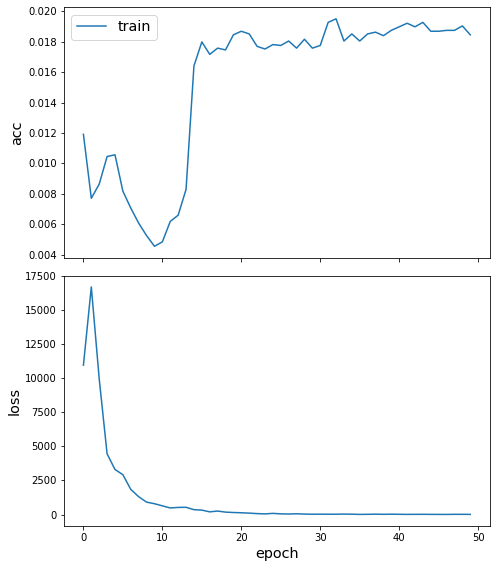

In [42]:
sg.utils.plot_history(history)

In [29]:
test_metrics = model.evaluate(train_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 7s 7s/step - loss: 0.0059 - acc: 0.0194

Test Set Metrics:
	loss: 0.0059
	acc: 0.0194


## prediction for genes of controls (GCN)

In [31]:
all_mapper = generator.flow(controlsDK.index)
all_predictions = model.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddings = pd.DataFrame(all_predictions[0], index =controlsDK.index,columns =controlsDK.columns)

In [32]:
genesEmbeddings

,TCGA-E2-A1L7-11A-33R-A144-07,TCGA-BH-A0BC-11A-22R-A089-07,TCGA-E9-A1N9-11A-71R-A14D-07,TCGA-BH-A18P-11A-43R-A12D-07,TCGA-BH-A1FB-11A-33R-A13Q-07,TCGA-E9-A1RB-11A-33R-A157-07,TCGA-BH-A1EO-11A-31R-A137-07,TCGA-GI-A2C8-11A-22R-A16F-07,TCGA-E9-A1NA-11A-33R-A144-07,TCGA-BH-A0H9-11A-22R-A466-07,...,TCGA-BH-A0B5-11A-23R-A12P-07,TCGA-BH-A1F8-11B-21R-A13Q-07,TCGA-A7-A0CH-11A-32R-A089-07,TCGA-BH-A1FM-11B-23R-A13Q-07,TCGA-BH-A18K-11A-13R-A12D-07,TCGA-E9-A1NF-11A-73R-A14D-07,TCGA-BH-A18U-11A-23R-A12D-07,TCGA-BH-A208-11A-51R-A157-07,TCGA-BH-A1EW-11B-33R-A137-07,TCGA-BH-A204-11A-53R-A157-07
1,0.004692,-0.019996,0.036509,0.038886,-0.058539,0.034009,-0.013628,0.087353,-0.047503,-0.000832,...,-0.022554,0.048964,-0.069499,-0.044370,-0.088695,-0.164446,-0.025625,-0.075194,-0.058265,-0.014804
2,0.004692,-0.019996,0.036509,0.038886,-0.058539,0.034009,-0.013628,0.087353,-0.047503,-0.000832,...,-0.022554,0.048964,-0.069499,-0.044370,-0.088695,-0.164446,-0.025625,-0.075194,-0.058265,-0.014804
9,0.004692,-0.019996,0.036509,0.038886,-0.058539,0.034009,-0.013628,0.087353,-0.047503,-0.000832,...,-0.022554,0.048964,-0.069499,-0.044370,-0.088695,-0.164446,-0.025625,-0.075194,-0.058265,-0.014804
10,0.004692,-0.019996,0.036509,0.038886,-0.058539,0.034009,-0.013628,0.087353,-0.047503,-0.000832,...,-0.022554,0.048964,-0.069499,-0.044370,-0.088695,-0.164446,-0.025625,-0.075194,-0.058265,-0.014804
12,0.004692,-0.019996,0.036509,0.038886,-0.058539,0.034009,-0.013628,0.087353,-0.047503,-0.000832,...,-0.022554,0.048964,-0.069499,-0.044370,-0.088695,-0.164446,-0.025625,-0.075194,-0.058265,-0.014804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100302401,0.003171,-0.022571,0.039229,0.039760,-0.058792,0.035916,-0.014336,0.084949,-0.043640,-0.000654,...,-0.018764,0.047488,-0.070226,-0.046412,-0.088168,-0.165230,-0.021847,-0.073294,-0.057663,-0.013892
100302640,0.004692,-0.019996,0.036509,0.038886,-0.058539,0.034009,-0.013628,0.087353,-0.047503,-0.000832,...,-0.022554,0.048964,-0.069499,-0.044370,-0.088695,-0.164446,-0.025625,-0.075194,-0.058265,-0.014804
100302692,0.004692,-0.019996,0.036509,0.038886,-0.058539,0.034009,-0.013628,0.087353,-0.047503,-0.000832,...,-0.022554,0.048964,-0.069499,-0.044370,-0.088695,-0.164446,-0.025625,-0.075194,-0.058265,-0.014804
100302736,0.004692,-0.019996,0.036509,0.038886,-0.058539,0.034009,-0.013628,0.087353,-0.047503,-0.000832,...,-0.022554,0.048964,-0.069499,-0.044370,-0.088695,-0.164446,-0.025625,-0.075194,-0.058265,-0.014804


<AxesSubplot:>

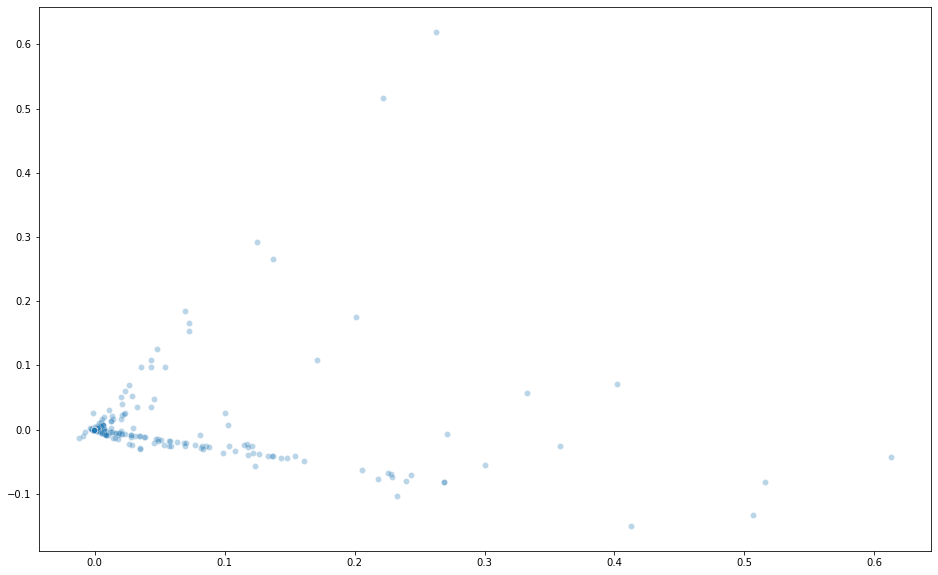

In [33]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddings)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

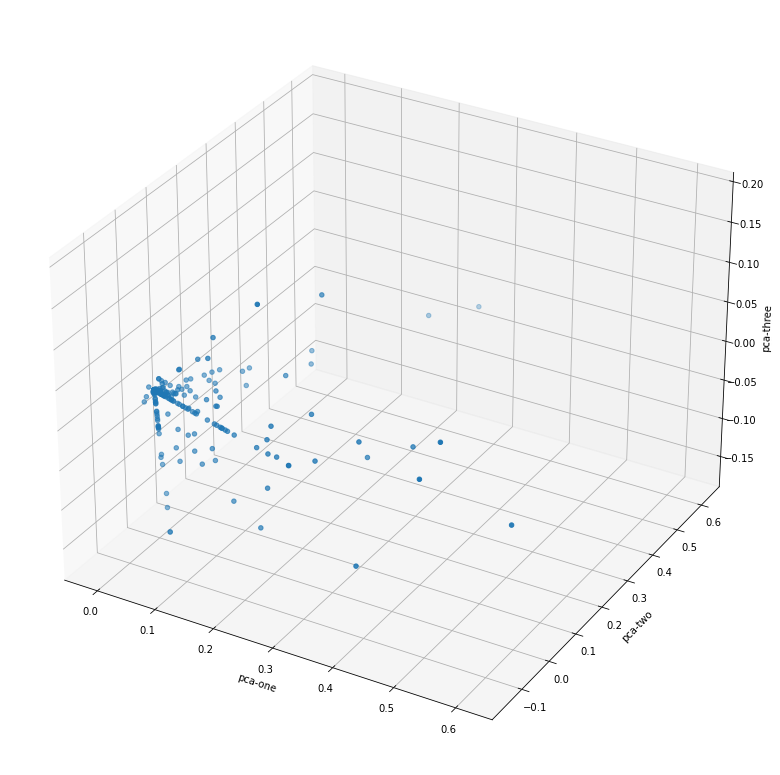

In [34]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## GRAPHSAGE (controls)

10 nodes in the first layer(5 in and 5 out) and 4 nodes in the second layer

In [15]:
batch_size = controlsDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_size

17129

In [16]:
generator = DirectedGraphSAGENodeGenerator(directedGraph, batch_size, in_samples, out_samples)

In [17]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGen = generator.flow(controlsDK.index, controlsDK)

graphsage_model = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=False, dropout=0.5,
)

x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=controlsDK.shape[1], activation="softmax")(x_out)

In [18]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTest,constantTensor=constantTensor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 113)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 5, 113)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 10, 113)]    0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 10, 113)]    0           []                               
                                                                                              

In [19]:
checkpointPath = "model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt"
checkpointDir = os.path.dirname(checkpointPath)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPath,
                                                 save_weights_only=True,
                                                 verbose=1)


model.load_weights(checkpointPath)

In [73]:
history = model.fit(
    trainGen, epochs=5, 
    #validation_data=test_gen,
    batch_size=batch_size,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/5

Epoch 1: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 24s - loss: 0.8474 - acc: 0.0022 - 24s/epoch - 24s/step
Epoch 2/5

Epoch 2: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 24s - loss: 0.8164 - acc: 0.0021 - 24s/epoch - 24s/step
Epoch 3/5

Epoch 3: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 24s - loss: 0.7685 - acc: 0.0022 - 24s/epoch - 24s/step
Epoch 4/5

Epoch 4: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 24s - loss: 0.7470 - acc: 0.0021 - 24s/epoch - 24s/step
Epoch 5/5

Epoch 5: saving model to model_checkpoints/GRAPHSAGEcontrolsGenes.ckpt
1/1 - 24s - loss: 0.6967 - acc: 0.0019 - 24s/epoch - 24s/step


In [74]:
model.save_weights(checkpointPath.format(epoch=0))

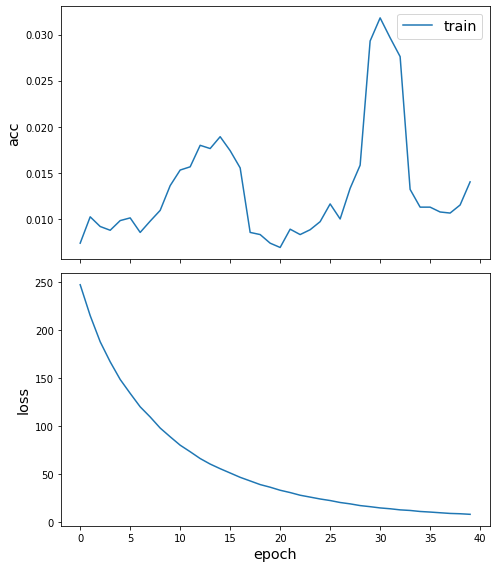

In [ ]:
sg.utils.plot_history(history)

## prediction for genes of controls (GRAPHSAGE)

In [20]:
all_mapper = generator.flow(controlsDK.index)
all_predictions = model.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddings = pd.DataFrame(all_predictions, index =controlsDK.index,columns =controlsDK.columns)

In [21]:
genesEmbeddings

,TCGA-E2-A1L7-11A-33R-A144-07,TCGA-BH-A0BC-11A-22R-A089-07,TCGA-E9-A1N9-11A-71R-A14D-07,TCGA-BH-A18P-11A-43R-A12D-07,TCGA-BH-A1FB-11A-33R-A13Q-07,TCGA-E9-A1RB-11A-33R-A157-07,TCGA-BH-A1EO-11A-31R-A137-07,TCGA-GI-A2C8-11A-22R-A16F-07,TCGA-E9-A1NA-11A-33R-A144-07,TCGA-BH-A0H9-11A-22R-A466-07,...,TCGA-BH-A0B5-11A-23R-A12P-07,TCGA-BH-A1F8-11B-21R-A13Q-07,TCGA-A7-A0CH-11A-32R-A089-07,TCGA-BH-A1FM-11B-23R-A13Q-07,TCGA-BH-A18K-11A-13R-A12D-07,TCGA-E9-A1NF-11A-73R-A14D-07,TCGA-BH-A18U-11A-23R-A12D-07,TCGA-BH-A208-11A-51R-A157-07,TCGA-BH-A1EW-11B-33R-A137-07,TCGA-BH-A204-11A-53R-A157-07
1,0.008527,0.010250,0.010018,0.010582,0.008912,0.008873,0.007297,0.009041,0.010026,0.007450,...,0.009764,0.007534,0.007801,0.010059,0.008067,0.007312,0.008898,0.007361,0.009981,0.010343
2,0.008493,0.010263,0.009991,0.010597,0.008944,0.008875,0.007285,0.009046,0.010035,0.007482,...,0.009755,0.007547,0.007790,0.010050,0.008065,0.007310,0.008887,0.007339,0.009983,0.010318
9,0.008526,0.010253,0.010018,0.010582,0.008912,0.008871,0.007300,0.009043,0.010025,0.007449,...,0.009764,0.007537,0.007797,0.010059,0.008068,0.007314,0.008900,0.007358,0.009980,0.010342
10,0.008441,0.010150,0.010007,0.010657,0.008781,0.008829,0.007374,0.009155,0.010149,0.007679,...,0.009820,0.007836,0.007624,0.010096,0.007982,0.007419,0.008907,0.007191,0.010017,0.010353
12,0.008526,0.010252,0.010018,0.010582,0.008912,0.008872,0.007299,0.009043,0.010025,0.007449,...,0.009764,0.007537,0.007798,0.010059,0.008068,0.007314,0.008899,0.007359,0.009980,0.010342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100302401,0.008490,0.010274,0.010017,0.010533,0.008868,0.008839,0.007299,0.009085,0.010027,0.007523,...,0.009771,0.007598,0.007764,0.010102,0.008075,0.007334,0.008858,0.007306,0.009960,0.010298
100302640,0.008321,0.010264,0.009935,0.010551,0.008755,0.008814,0.007444,0.009180,0.010081,0.007760,...,0.009733,0.007872,0.007624,0.010070,0.008021,0.007376,0.008955,0.007104,0.010024,0.010398
100302692,0.008525,0.010252,0.010017,0.010581,0.008912,0.008872,0.007300,0.009043,0.010024,0.007450,...,0.009764,0.007538,0.007797,0.010059,0.008068,0.007313,0.008902,0.007358,0.009981,0.010343
100302736,0.008520,0.010253,0.010015,0.010580,0.008911,0.008875,0.007301,0.009043,0.010025,0.007455,...,0.009760,0.007534,0.007795,0.010057,0.008070,0.007305,0.008907,0.007357,0.009983,0.010347


Column names are only **indicative**, they are not the patients since these features are the embeddings.

<AxesSubplot:>

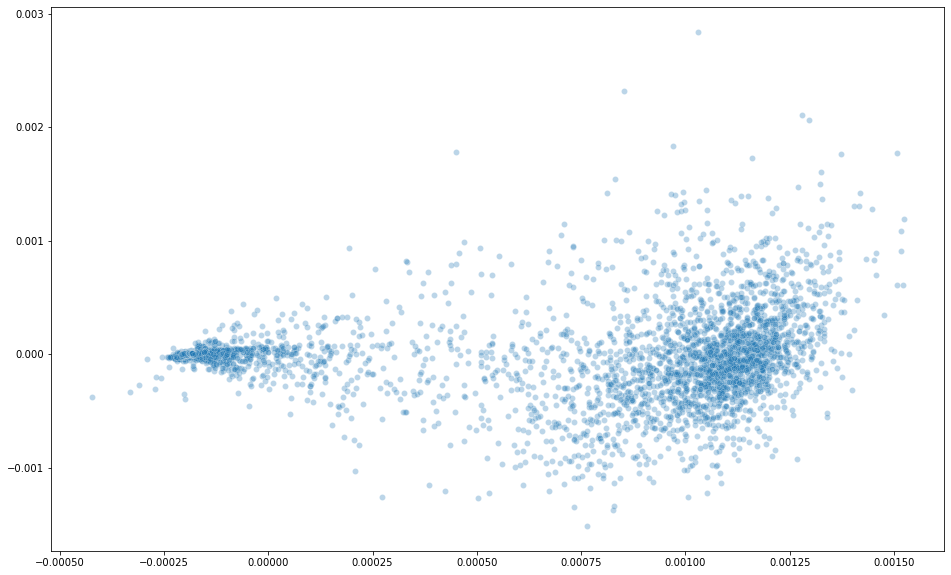

In [22]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddings)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

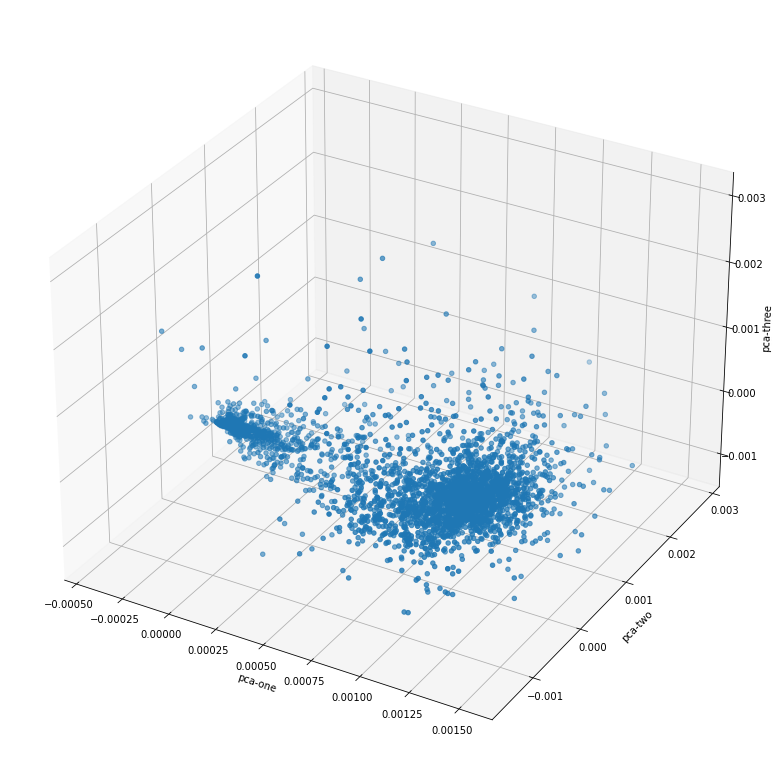

In [23]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# Genes embeddings for Tumors

In [35]:
graphTumorWithFeatures = sg.StellarGraph(tumorDKfull ,geneEdgesTumor )
print(graphTumorWithFeatures.info())

StellarGraph: Undirected multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 1082
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [36]:
generatorTumor = FullBatchNodeGenerator(graphTumorWithFeatures, method="gcn")
trainGenTumor = generatorTumor.flow(tumorDKfull.index,tumorDKfull)
gcnTumor = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generatorTumor, dropout=0.5
)

Using GCN (local pooling) filters...


In [37]:
x_inpTumor, x_outTumor = gcnTumor.in_out_tensors()
predictionsTumorFull = layers.Dense(tumorDKfull.shape[1], kernel_initializer='normal')(x_outTumor)

In [24]:
indexOfGenesTumor = dict()

for i in range(0,len(tumorDKfull.index)):
    indexOfGenesTumor[tumorDKfull.index[i]] = i

tensorEdgesTumor = tf.constant(geneEdgesTumor,tf.int32)
tensorEdgesTestTumor = tf.map_fn(lambda row: tf.map_fn(lambda element:indexOfGenesTumor[element.numpy()],tf.gather(row, [0, 1]).numpy()) ,tensorEdgesTumor)  # take only edges with no weight

**using the full dataset for the constant vector used in the loss function for both the reduced dataset(with less columns) and the full dataset since the final product is the same**

In [25]:
tfTumor = tf.constant(tumorDK,tf.float32)
#difference_of_edge_genes_embedding(tensorEdgesTest[3],tfControls)
maxDegreeTumor = 0

for gene in list(tumorDK.index):
    if(len(inAdjacencyListMetapathways[str(gene)]) + len(outAdjacencyListMetapathways[str(gene)]) > maxDegreeTumor):
        maxDegreeTumor = len(inAdjacencyListMetapathways[str(gene)]) + len(outAdjacencyListMetapathways[str(gene)])

precompConstantListTumor,constantTensorTumor = precomputeCostantsTensor(tensorEdgesTumor,inAdjacencyListMetapathways,outAdjacencyListMetapathways,maxDegreeTumor)
constantTensorTumor

<tf.Tensor: shape=(17264,), dtype=float32, numpy=
array([0.24344024, 0.35568514, 0.35568514, ..., 0.20991254, 0.20991254,
       0.20991254], dtype=float32)>

In [41]:
modelTumor = Model(inputs=x_inpTumor , outputs=predictionsTumorFull)

modelTumor.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    #loss=genes_loss_with_closure_weighted(edges=tensorEdgesTest,inAdjacencyListMetapathways=inAdjacencyListMetapathways,outAdjacencyListMetapathways=outAdjacencyListMetapathways),
    loss = optimized_loss(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    metrics=["acc"])

In [42]:
modelTumor.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(1, 19727, 1082)]   0           []                               
                                                                                                  
 input_7 (InputLayer)           [(1, None, 2)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(1, None)]          0           []                               
                                                                                                  
 dropout_2 (Dropout)            (1, 19727, 1082)     0           ['input_5[0][0]']                
                                                                                            

In [43]:
checkpointPathTumor = "model_checkpoints/adamGenesTumor.ckpt"
checkpointDirTumor = os.path.dirname(checkpointPathTumor)

# Create a callback that saves the model's weights
cp_callbackTumor = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumor,
                                                 save_weights_only=True,
                                                 verbose=1)

modelTumor.load_weights(checkpointPathTumor)

In [103]:
historyTumor = modelTumor.fit(
    trainGenTumor,
    epochs=10,
    #validation_data=val_gen,
    batch_size=tumorDKfull.shape[0],
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[cp_callbackTumor]
)

Epoch 1/10

Epoch 1: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 48.7121 - acc: 3.0415e-04 - 113s/epoch - 113s/step
Epoch 2/10

Epoch 2: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 16.3105 - acc: 4.0554e-04 - 113s/epoch - 113s/step
Epoch 3/10

Epoch 3: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 112s - loss: 18.2850 - acc: 1.0138e-04 - 112s/epoch - 112s/step
Epoch 4/10

Epoch 4: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 17.8057 - acc: 2.5346e-04 - 113s/epoch - 113s/step
Epoch 5/10

Epoch 5: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 25.7509 - acc: 2.0277e-04 - 113s/epoch - 113s/step
Epoch 6/10

Epoch 6: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 22.5953 - acc: 4.0554e-04 - 113s/epoch - 113s/step
Epoch 7/10

Epoch 7: saving model to model_checkpoints/adamGenesTumor.ckpt
1/1 - 113s - loss: 23.7553 - acc: 2.5346e-04 - 113s/epo

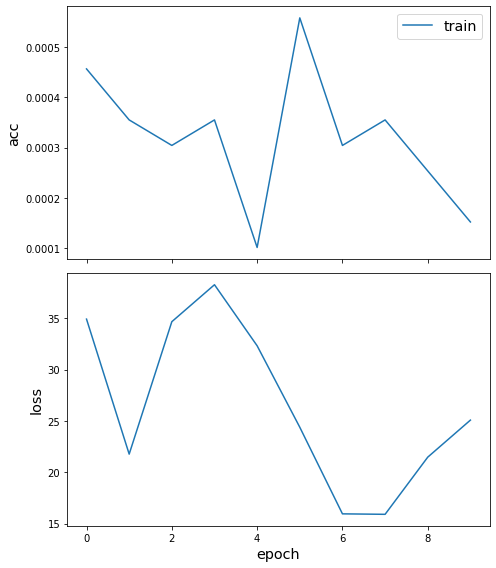

In [126]:
modelTumor.save_weights(checkpointPathTumor.format(epoch=0))
sg.utils.plot_history(historyTumor)

## prediction for genes of tumors (GCN)

In [45]:
all_mapper = generatorTumor.flow(tumorDKfull.index)
all_predictions = modelTumor.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumor = pd.DataFrame(all_predictions[0], index =tumorDKfull.index,columns =tumorDKfull.columns)

In [46]:
genesEmbeddingsTumor

,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
2,0.077756,0.024824,-0.013002,-0.034736,0.055104,0.037664,0.052124,0.02696,0.012788,-0.045989,...,0.025012,0.034019,0.027135,0.013607,-0.033031,-0.013939,-0.051558,-0.083843,-0.013089,0.051307
3,0.077756,0.024824,-0.013002,-0.034736,0.055104,0.037664,0.052124,0.02696,0.012788,-0.045989,...,0.025012,0.034019,0.027135,0.013607,-0.033031,-0.013939,-0.051558,-0.083843,-0.013089,0.051307
7,0.077756,0.024824,-0.013002,-0.034736,0.055104,0.037664,0.052124,0.02696,0.012788,-0.045989,...,0.025012,0.034019,0.027135,0.013607,-0.033031,-0.013939,-0.051558,-0.083843,-0.013089,0.051307
8,0.077756,0.024824,-0.013002,-0.034736,0.055104,0.037664,0.052124,0.02696,0.012788,-0.045989,...,0.025012,0.034019,0.027135,0.013607,-0.033031,-0.013939,-0.051558,-0.083843,-0.013089,0.051307
10,0.077756,0.024824,-0.013002,-0.034736,0.055104,0.037664,0.052124,0.02696,0.012788,-0.045989,...,0.025012,0.034019,0.027135,0.013607,-0.033031,-0.013939,-0.051558,-0.083843,-0.013089,0.051307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20526,0.077756,0.024824,-0.013002,-0.034736,0.055104,0.037664,0.052124,0.02696,0.012788,-0.045989,...,0.025012,0.034019,0.027135,0.013607,-0.033031,-0.013939,-0.051558,-0.083843,-0.013089,0.051307
20527,0.077756,0.024824,-0.013002,-0.034736,0.055104,0.037664,0.052124,0.02696,0.012788,-0.045989,...,0.025012,0.034019,0.027135,0.013607,-0.033031,-0.013939,-0.051558,-0.083843,-0.013089,0.051307
20528,0.077756,0.024824,-0.013002,-0.034736,0.055104,0.037664,0.052124,0.02696,0.012788,-0.045989,...,0.025012,0.034019,0.027135,0.013607,-0.033031,-0.013939,-0.051558,-0.083843,-0.013089,0.051307
20529,0.077756,0.024824,-0.013002,-0.034736,0.055104,0.037664,0.052124,0.02696,0.012788,-0.045989,...,0.025012,0.034019,0.027135,0.013607,-0.033031,-0.013939,-0.051558,-0.083843,-0.013089,0.051307


<AxesSubplot:>

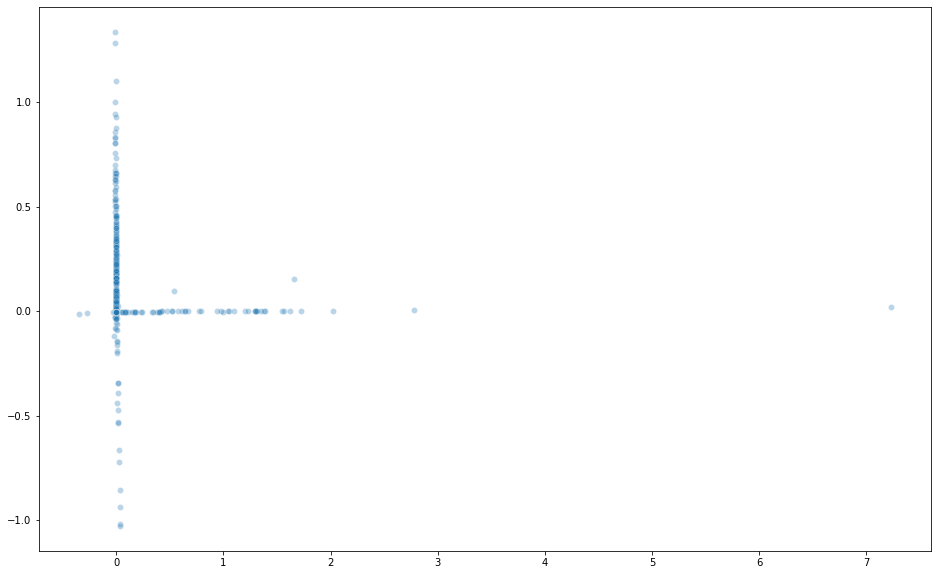

In [48]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumor)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

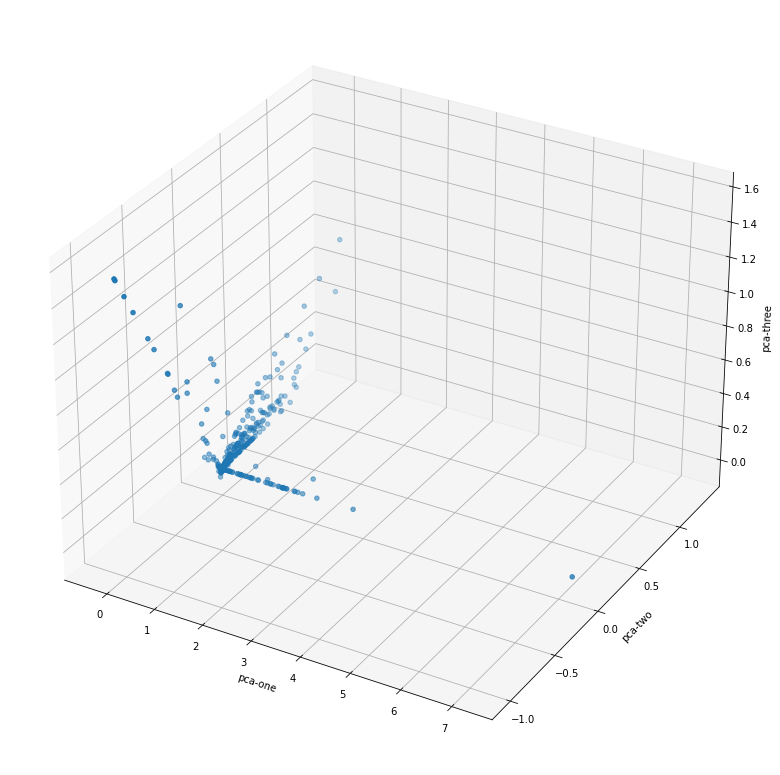

In [49]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## GRAPHSAGE for tumors

In [26]:
directedGraphTumor = sg.StellarDiGraph(tumorDK ,geneEdgesTumor)
print(directedGraphTumor.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 390
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [27]:
batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [28]:
generatorTumor = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

In [29]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumor = generatorTumor.flow(tumorDK.index, tumorDK)

graphsage_modelTumor = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumor, bias=False, dropout=0.5,
)

x_inpTumor, x_outTumor = graphsage_modelTumor.in_out_tensors()
predictionTumor = layers.Dense(units=tumorDK.shape[1], activation="softmax")(x_outTumor)


In [30]:
modelTumor = Model(inputs=x_inpTumor, outputs=predictionTumor)
modelTumor.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumor.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 5, 390)]     0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 5, 390)]     0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 10, 390)]    0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 10, 390)]    0           []                               
                                                                                            

In [31]:
checkpointPathTumor = "model_checkpoints/GRAPHSAGEtumorGenes.ckpt"
checkpointDirTumor = os.path.dirname(checkpointPathTumor)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumor,
                                                 save_weights_only=True,
                                                 verbose=1)


modelTumor.load_weights(checkpointPathTumor)

In [154]:
history = modelTumor.fit(
    trainGenTumor, epochs=5, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/5

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 29s - loss: 22.5018 - acc: 0.0020 - 29s/epoch - 29s/step
Epoch 2/5

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 28s - loss: 19.4920 - acc: 0.0023 - 28s/epoch - 28s/step
Epoch 3/5

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 28s - loss: 16.6755 - acc: 0.0026 - 28s/epoch - 28s/step
Epoch 4/5

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 28s - loss: 14.4173 - acc: 0.0028 - 28s/epoch - 28s/step
Epoch 5/5

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenes.ckpt
1/1 - 28s - loss: 12.4791 - acc: 0.0026 - 28s/epoch - 28s/step


In [36]:
modelTumor.save_weights(checkpointPathTumor.format(epoch=0))

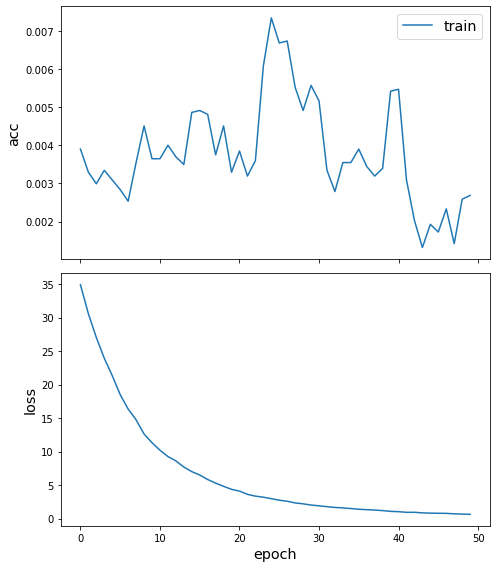

In [37]:
sg.utils.plot_history(history)

## prediction for genes of tumors

In [32]:
all_mapper = generatorTumor.flow(tumorDK.index)
all_predictions = modelTumor.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumor = pd.DataFrame(all_predictions, index =tumorDK.index,columns =tumorDK.columns)

In [33]:
genesEmbeddingsTumor

,TCGA-A2-A1FX-01,TCGA-D8-A1XB-01,TCGA-BH-A0E1-01,TCGA-AQ-A04J-01,TCGA-BH-A0E9-01,TCGA-C8-A133-01,TCGA-B6-A0IG-01,TCGA-LL-A8F5-01,TCGA-E2-A14Q-01,TCGA-AR-A2LQ-01,...,TCGA-A2-A0YI-01,TCGA-A2-A4S1-01,TCGA-A8-A07B-01,TCGA-AC-A5XS-01,TCGA-GM-A5PV-01,TCGA-A1-A0SI-01,TCGA-AC-A2BK-01,TCGA-OL-A5DA-01,TCGA-AR-A254-01,TCGA-B6-A0I9-01
2,0.002378,0.002538,0.002782,0.002773,0.002270,0.002650,0.002550,0.002637,0.002752,0.002451,...,0.002650,0.002624,0.002439,0.002553,0.002443,0.002731,0.002479,0.002661,0.002531,0.002570
3,0.002292,0.002693,0.002620,0.002680,0.002469,0.002785,0.002758,0.002473,0.002703,0.002584,...,0.002605,0.002619,0.002534,0.002448,0.002383,0.002700,0.002484,0.002477,0.002636,0.002746
7,0.002283,0.002556,0.002729,0.002687,0.002410,0.002707,0.002626,0.002627,0.002632,0.002548,...,0.002689,0.002625,0.002548,0.002601,0.002496,0.002718,0.002583,0.002548,0.002579,0.002644
8,0.002285,0.002555,0.002727,0.002684,0.002409,0.002706,0.002631,0.002621,0.002634,0.002551,...,0.002693,0.002622,0.002553,0.002600,0.002504,0.002724,0.002585,0.002561,0.002583,0.002638
10,0.002277,0.002548,0.002714,0.002685,0.002406,0.002683,0.002643,0.002642,0.002658,0.002530,...,0.002708,0.002626,0.002550,0.002600,0.002497,0.002710,0.002595,0.002558,0.002596,0.002639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20526,0.002235,0.002796,0.002645,0.002746,0.002506,0.002712,0.002753,0.002465,0.002780,0.002595,...,0.002638,0.002673,0.002506,0.002396,0.002429,0.002670,0.002386,0.002428,0.002662,0.002683
20527,0.002275,0.002579,0.002748,0.002705,0.002426,0.002725,0.002598,0.002593,0.002603,0.002579,...,0.002677,0.002638,0.002522,0.002590,0.002505,0.002708,0.002542,0.002527,0.002579,0.002621
20528,0.002295,0.002541,0.002706,0.002674,0.002392,0.002679,0.002650,0.002658,0.002672,0.002507,...,0.002721,0.002627,0.002569,0.002614,0.002488,0.002713,0.002625,0.002573,0.002591,0.002639
20529,0.002285,0.002562,0.002724,0.002689,0.002426,0.002717,0.002613,0.002599,0.002616,0.002556,...,0.002689,0.002633,0.002526,0.002590,0.002496,0.002691,0.002564,0.002541,0.002589,0.002622


As already said, column names are only **indicative**, they are not the patients since these features are the embeddings.

### visualizzazione dati di espressione

<AxesSubplot:>

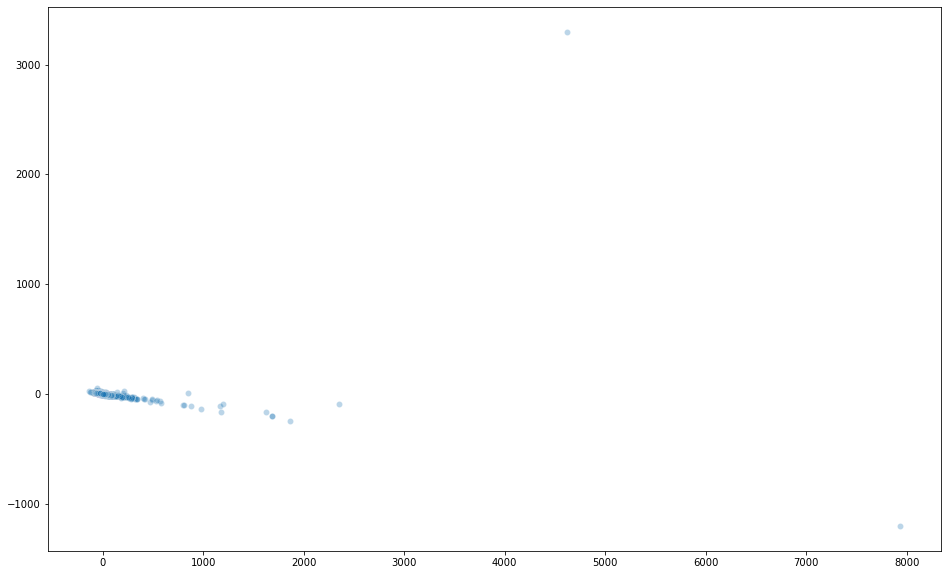

In [34]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(tumorDK)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

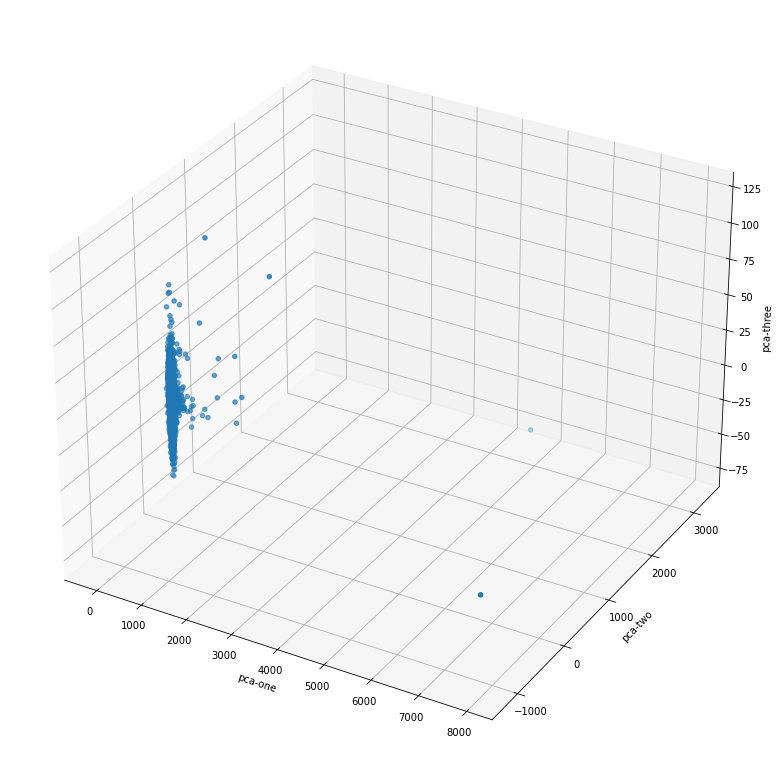

In [74]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### visualizzazione embeddings

<AxesSubplot:>

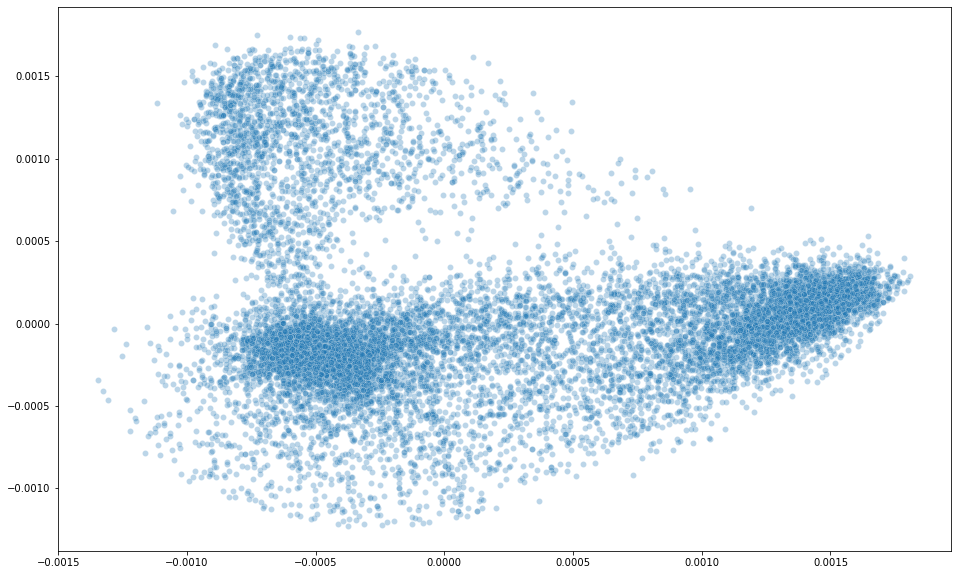

In [35]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumor)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

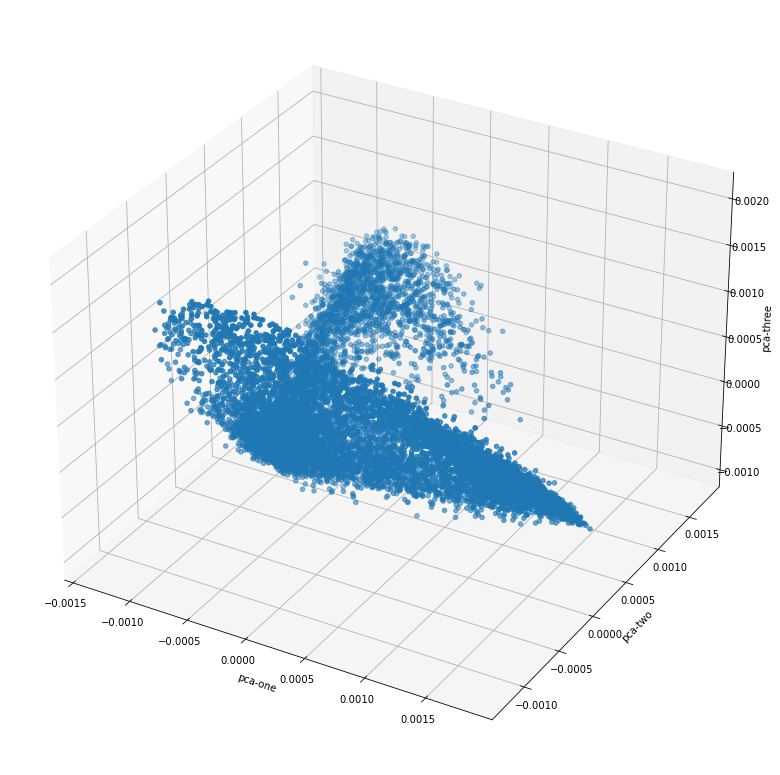

In [36]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## GRAPHSAGE for tumors(same number of features as controls)

In [37]:
#tumorDKfinal = tumorDKfull.sample(n=controlsDK.shape[1], axis='columns', random_state=2)
tumorDKfinal = tumorDKfull.iloc[: , :controlsDK.shape[1]]
directedGraphTumorfinal = sg.StellarDiGraph(tumorDKfinal ,geneEdgesTumor)
print(directedGraphTumorfinal.info())

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 113
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none


In [38]:
batch_sizeTumor = int(tumorDKfinal.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]
batch_sizeTumor

19727

In [39]:
generatorTumorfinal = DirectedGraphSAGENodeGenerator(directedGraphTumorfinal, batch_sizeTumor, in_samples, out_samples)

In [40]:
#train_gen = generator.flow(train_subjects.index, train_subjects)
#val_gen = generator.flow(val_subjects.index, val_subjects)
trainGenTumorfinal = generatorTumorfinal.flow(tumorDKfinal.index, tumorDKfinal)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorfinal, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=tumorDKfinal.shape[1], activation="softmax")(x_outTumorfinal)


In [41]:
modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 5, 113)]     0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 10, 113)]    0           []                               
                                                                                            

In [42]:
checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)


modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [119]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 15s - loss: 1.9562 - acc: 0.0068 - 15s/epoch - 15s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 15s - loss: 1.9475 - acc: 0.0050 - 15s/epoch - 15s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 15s - loss: 1.7388 - acc: 0.0034 - 15s/epoch - 15s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 16s - loss: 1.7063 - acc: 0.0034 - 16s/epoch - 16s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 16s - loss: 1.5977 - acc: 0.0033 - 16s/epoch - 16s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patients.ckpt
1/1 - 15s - loss: 1.5195 - acc: 0.0032 - 15s/epoch - 15s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenes113Patie

In [120]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

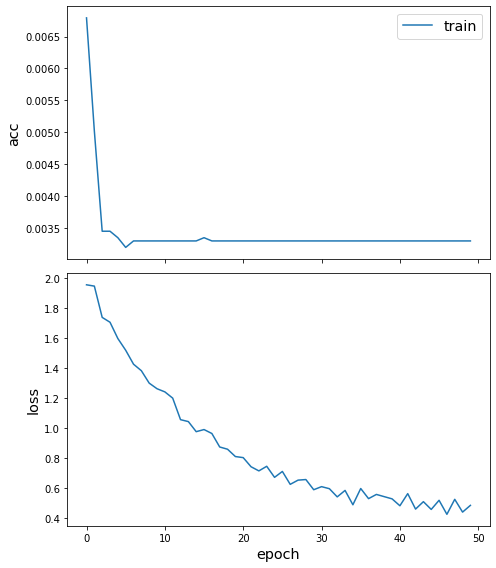

In [121]:
sg.utils.plot_history(history)

### generazione embedding per tumor con lo stesso numero di feature di control

In [43]:
all_mapper = generatorTumorfinal.flow(tumorDKfinal.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorfinal = pd.DataFrame(all_predictions, index =tumorDKfinal.index,columns =tumorDKfinal.columns)

In [44]:
genesEmbeddingsTumorfinal

,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,...,TCGA-A2-A25F-01,TCGA-A2-A3KC-01,TCGA-A2-A3KD-01,TCGA-A2-A3XS-01,TCGA-A2-A3XT-01,TCGA-A2-A3XU-01,TCGA-A2-A3XV-01,TCGA-A2-A3XW-01,TCGA-A2-A3XX-01,TCGA-A2-A3XY-01
2,0.006832,0.006949,0.007543,0.006660,0.009087,0.010477,0.010361,0.007585,0.006659,0.008082,...,0.009688,0.009826,0.007555,0.009018,0.010200,0.009970,0.010301,0.010654,0.006951,0.010085
3,0.006834,0.006957,0.007542,0.006666,0.009085,0.010482,0.010368,0.007603,0.006662,0.008072,...,0.009688,0.009829,0.007539,0.009023,0.010202,0.009974,0.010303,0.010653,0.006961,0.010084
7,0.006835,0.006959,0.007541,0.006660,0.009084,0.010472,0.010371,0.007585,0.006656,0.008076,...,0.009693,0.009835,0.007543,0.009019,0.010198,0.009966,0.010302,0.010657,0.006955,0.010081
8,0.006834,0.006959,0.007540,0.006660,0.009085,0.010472,0.010372,0.007585,0.006655,0.008076,...,0.009693,0.009836,0.007543,0.009019,0.010199,0.009966,0.010302,0.010657,0.006955,0.010081
10,0.006835,0.006960,0.007540,0.006660,0.009086,0.010473,0.010371,0.007587,0.006656,0.008075,...,0.009692,0.009835,0.007543,0.009020,0.010199,0.009967,0.010302,0.010656,0.006956,0.010081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20526,0.006831,0.006956,0.007538,0.006660,0.009084,0.010479,0.010368,0.007591,0.006658,0.008081,...,0.009694,0.009831,0.007548,0.009020,0.010200,0.009978,0.010304,0.010652,0.006959,0.010082
20527,0.006834,0.006959,0.007540,0.006660,0.009085,0.010472,0.010371,0.007584,0.006655,0.008076,...,0.009693,0.009836,0.007544,0.009019,0.010198,0.009966,0.010302,0.010657,0.006955,0.010081
20528,0.006834,0.006960,0.007540,0.006660,0.009086,0.010473,0.010371,0.007587,0.006656,0.008076,...,0.009693,0.009836,0.007543,0.009020,0.010199,0.009968,0.010302,0.010655,0.006956,0.010081
20529,0.006834,0.006959,0.007540,0.006660,0.009085,0.010472,0.010372,0.007585,0.006655,0.008076,...,0.009693,0.009836,0.007544,0.009019,0.010198,0.009966,0.010302,0.010657,0.006955,0.010081


### visualizzazione embeddings (stesso numero di feature-pazienti di controls)

<AxesSubplot:>

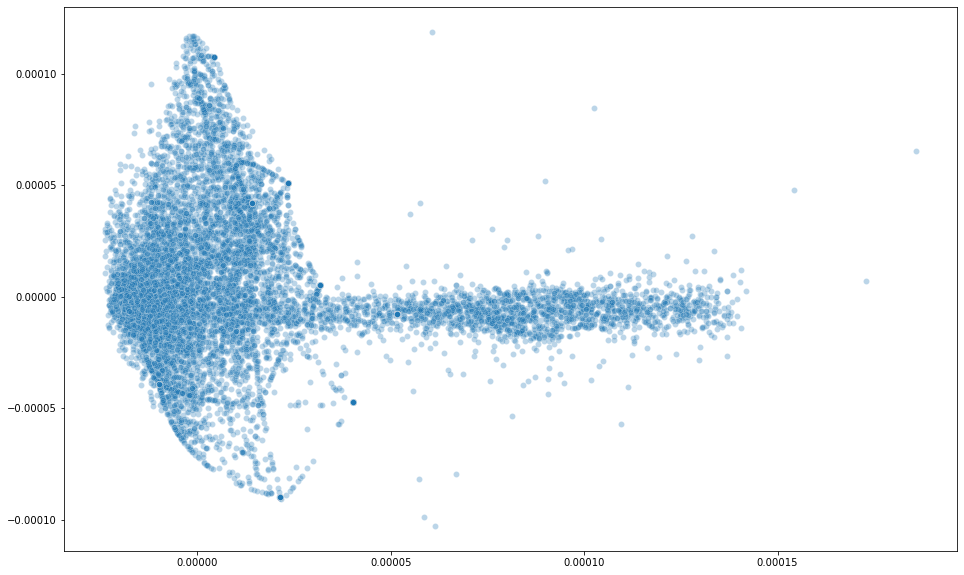

In [45]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorfinal)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

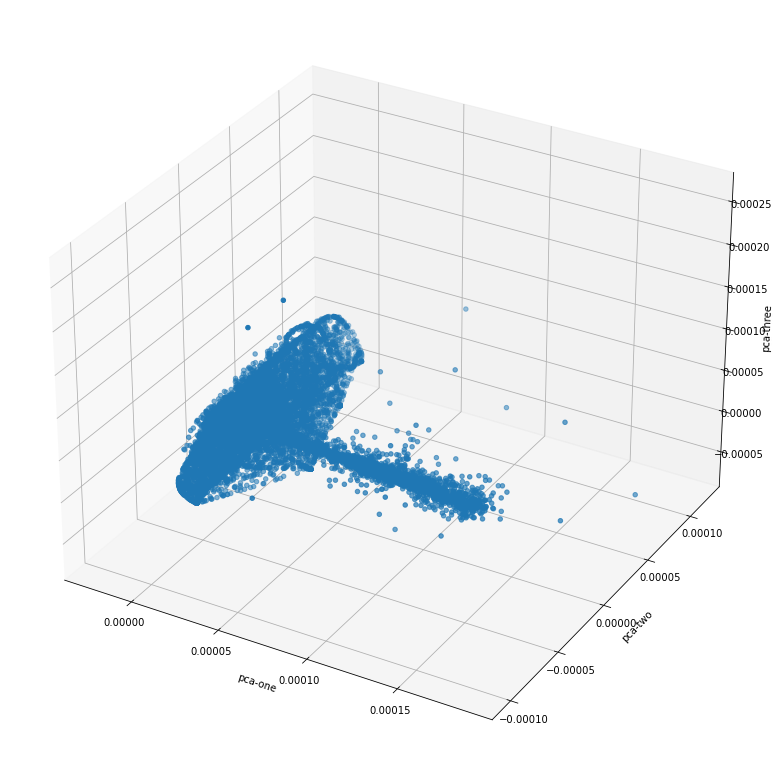

In [46]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# Pathway embedding

## Pathway embeddings for controls

In [47]:
tfDatasetGenesExpressions = tf.data.Dataset.from_tensor_slices((genesEmbeddings.index,genesEmbeddings.values))
normalizer_constant = genesEmbeddings.max().max()
normalizer_constant

0.011026228778064251

In [48]:
def printDS(dataset):
    for index,elem in dataset:
      print(elem.numpy())

listatest =  ['3915','79728','3293'] 
listatest = list(map(int, listatest))

keys_tensor = tf.constant(listatest,dtype=tf.int64)
vals_tensor = tf.ones_like(keys_tensor)  # Ones will be casted to True.

table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
    default_value=0)  # If index not in table, return 0.


def hash_table_filter(index, value):
    table_value = table.lookup(index)  # 1 if index in arr, else 0.
    index_in_arr =  tf.cast(table_value, tf.bool) # 1 -> True, 0 -> False
    return index_in_arr

def filterdatasetOnIndex(ds):
    return ds.filter(hash_table_filter)

filtered = tfDatasetGenesExpressions.apply(filterdatasetOnIndex)
single = filtered.map(lambda index,value : value).reduce(np.float64(0.0),lambda x,y: x+y)/ len(listatest)
#single.numpy()

In [ ]:
def getPartialVec(Nodes):
    listatest =  Nodes.split(";")  
    listatest = list(map(int, listatest))  

    keys_tensor = tf.constant(listatest,dtype=tf.int64)
    vals_tensor = tf.ones_like(keys_tensor)  # Ones will be casted to True.

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0)  # If index not in table, return 0.

    def hash_table_filter(index, value):
        table_value = table.lookup(index)  # 1 if index in arr, else 0.
        index_in_arr =  tf.cast(table_value, tf.bool) # 1 -> True, 0 -> False
        return index_in_arr

    tfFiltered = tfDatasetGenesExpressions.filter(hash_table_filter)
    tfFiltered = tfFiltered.map(lambda index,value : value).reduce(np.float64(0.0),lambda x,y: x+y)/ (len(listatest) * normalizer_constant)  #additional normalization by 100 000, otherwise with normalization costant, that is the maximum of all the record genes 
    return tfFiltered.numpy()
    

pathways["partialsVectors"] = pathways["nodes"].map(getPartialVec)

In [92]:
pathways["partialsVectors"].where(pathways["partialsVectors"].map(lambda value: not not value.shape))[108:115].dropna()

108    [0.67769991541981, 0.878125138963689, 0.863787...
109    [0.5714204395029235, 0.7351661989828722, 0.719...
110    [0.6412487561744828, 0.8319148352708167, 0.812...
112    [0.6243826700035979, 0.8087988187178508, 0.795...
113    [0.6684047947844219, 0.8664241449782568, 0.851...
114    [0.43777770319531917, 0.5652509376604615, 0.55...
Name: partialsVectors, dtype: object

In [93]:
pathways["partialsVectors"] = pathways["partialsVectors"].where(pathways["partialsVectors"].map(lambda value: not not value.shape))
pathways = pathways.dropna()

In [96]:
sigmoid = lambda x: 1.0 / (1.0 + math.exp(-x))
vfunc = np.vectorize(sigmoid)
#vfunc(pathways["partialsVectors"][0])
# problemi con numeri grandi, il risultato finale sono vettori di tutti 1

In [97]:
def getPathwayEmbedding(partialVec,Wmat):
    partialvec_tensor = tf.constant(partialVec,dtype=tf.float64)
    W_tensor = Wmat #tf.constant(Wmat,dtype=tf.float64)  #Wmat could be already a tensor
    trasformedPartialVec = tf.linalg.matvec(W_tensor,partialvec_tensor)  #W_tensor @ partialvec_tensor
    finalVec = tf.map_fn(sigmoid,trasformedPartialVec)
    return finalVec


W = np.diag(np.full(len(pathways["partialsVectors"][0]),0.001))
W_tensor = tf.Variable(W,dtype=tf.float64)
pathways["pathwayEmbeddings"] = pathways["partialsVectors"].map(lambda value: getPathwayEmbedding(value,W_tensor))
pathways["pathwayEmbeddings"]

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


0      (tf.Tensor(0.5001567129104318, shape=(), dtype...
1      (tf.Tensor(0.5001758787160123, shape=(), dtype...
2      (tf.Tensor(0.5001553040206834, shape=(), dtype...
3      (tf.Tensor(0.500150924151691, shape=(), dtype=...
4      (tf.Tensor(0.5001664954249907, shape=(), dtype...
                             ...                        
222    (tf.Tensor(0.5001651625487111, shape=(), dtype...
223    (tf.Tensor(0.5001614764963508, shape=(), dtype...
224    (tf.Tensor(0.5001459028055929, shape=(), dtype...
225    (tf.Tensor(0.5001780410939087, shape=(), dtype...
226    (tf.Tensor(0.5001625625108851, shape=(), dtype...
Name: pathwayEmbeddings, Length: 226, dtype: object

In [ ]:
@tf.function
def sigmoid_log(x):
    return 1.0 / (1.0 + tf.math.exp(-tf.math.log(x)))

@tf.function( experimental_relax_shapes=True)
def getPathwayEmbeddingEnhancedFinal(partialsVec_tensor,Wmat):
    W_tensor = Wmat #tf.constant(Wmat,dtype=tf.float64)  #Wmat could be already a tensor
    trasformedPartialVec = W_tensor @ partialsVec_tensor
    finalVec = tf.map_fn(lambda values: tf.map_fn(tf.nn.leaky_relu,values),trasformedPartialVec)
    return finalVec

npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W_tensor)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist() #tf.make_ndarray(finalVectors_tensors)
#pathways["pathwayEmbeddings"][0]

In [99]:
loss = tf.Variable(0.0,dtype="float64")

@tf.function( experimental_relax_shapes=True)
def getLoss(pathwaysEmbeddingTensor,loss):
    for zPi in pathwaysEmbeddingTensor:
        #print(zPi.get_shape())
        for zPj in pathwaysEmbeddingTensor:
            loss = loss + tf.sqrt(tf.reduce_sum(tf.square(zPi - zPj)) + 1.0e-12)   #tf.norm is unstable
    return loss

firstLoss = getLoss(tf.transpose(finalVectors_tensors),loss).numpy()

In [100]:
firstLoss

43.860130440314244

In [101]:
W_numpy = np.diag(np.full(len(pathways["partialsVectors"][0]),0.01))
W = tf.Variable(W_numpy,dtype=tf.float64,name = "W")
npPartial = np.stack(pathways["partialsVectors"]).transpose()
partialsVectors_tensor = tf.constant(npPartial)  #tf.make_tensor_proto(npPartial)
loss = tf.Variable(0.0,dtype="float64")

with tf.GradientTape(persistent=True) as tape:
    loss.assign(0.0)
    tape.watch(W)
    finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
    loss = getLoss(tf.transpose(finalVectors_tensors),loss)


In [102]:
dl_dw = tape.gradient(loss, W)
dl_dw

<tf.Tensor: shape=(113, 113), dtype=float64, numpy=
array([[271.65137725, 356.13418015, 347.13503034, ..., 354.52933299,
        278.23259847, 319.44449564],
       [356.13418015, 473.55654871, 461.08045733, ..., 469.192636  ,
        368.25299329, 422.04199803],
       [347.13503034, 461.08045733, 451.84513241, ..., 456.57307648,
        358.58613904, 410.43962103],
       ...,
       [354.52933299, 469.192636  , 456.57307648, ..., 465.97333724,
        365.58901916, 419.36651238],
       [278.23259847, 368.25299329, 358.58613904, ..., 365.58901916,
        287.0027388 , 329.07011663],
       [319.44449564, 422.04199803, 410.43962103, ..., 419.36651238,
        329.07011663, 377.86622465]])>

In [104]:
learning_rate = 0.0000000001
loss_progression = np.array([firstLoss])

for i in range(0,10):
    dl_dw = tape.gradient(loss, W)
    W.assign_sub(learning_rate * dl_dw)
    finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
    loss_progression = np.append(loss_progression,getLoss(tf.transpose(finalVectors_tensors),loss).numpy())

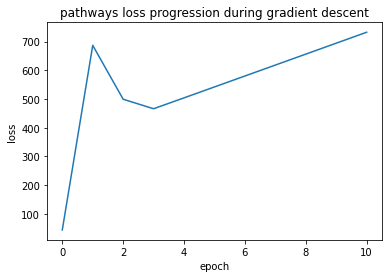

In [105]:
x = np.arange(0,11)
plt.title("pathways loss progression during gradient descent") 
plt.xlabel("epoch") 
plt.ylabel("loss") 
plt.plot(x,loss_progression) 
plt.show()

In [66]:
loss = tf.Variable(0.0,dtype="float64")
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W)
getLoss(tf.transpose(finalVectors_tensors),loss)

<tf.Tensor: shape=(), dtype=float64, numpy=6796.317250840886>

In [106]:
finalVectors_tensors = getPathwayEmbeddingEnhancedFinal(partialsVectors_tensor,W_tensor)
pathways["pathwayEmbeddings"]= finalVectors_tensors.numpy().transpose().tolist()

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [107]:
pathways

,pathway_id,pathway_name,nodes,partialsVectors,pathwayEmbeddings
0,path:hsa00190,Oxidative phosphorylation,64077;5464;245972;245973;479;513;514;515;516;5...,"[0.6268516622538295, 0.8111762074861479, 0.793...","[0.0006268516622538295, 0.000811176207486148, ..."
1,path:hsa00072,Synthesis and degradation of ketone bodies,64064;38;39;3155;56898;54511;622;3158;3157;5019,"[0.7035148930651846, 0.9068165692131339, 0.887...","[0.0007035148930651845, 0.0009068165692131339,..."
2,path:hsa01040,Biosynthesis of unsaturated fatty acids,641371;79966;6319;570;9415;3992;10965;122970;1...,"[0.6212161027113697, 0.809135156920701, 0.7897...","[0.0006212161027113697, 0.000809135156920701, ..."
3,path:hsa04672,Intestinal immune network for IgA production,4055;8174;959;8741;3600;23308;102723407;6370;5...,"[0.6036966250990019, 0.7798361418143757, 0.766...","[0.0006036966250990019, 0.0007798361418143757,..."
4,path:hsa03460,Fanconi anemia pathway,3280;378708;55120;672;84126;675;2189;83990;229...,"[0.6659817245779234, 0.8636345291024171, 0.847...","[0.0006659817245779234, 0.0008636345291024171,..."
...,...,...,...,...,...
222,path:hsa03013,RNA transport,8893;8891;8892;9984;8890;1975;340529;8662;8663...,"[0.6606502188733936, 0.8587301854295256, 0.838...","[0.0006606502188733936, 0.0008587301854295256,..."
223,path:hsa04340,Hedgehog signaling pathway,64399;122011;595;1456;1455;1454;1453;1452;6469...,"[0.6459060078587411, 0.8359579976192313, 0.821...","[0.0006459060078587411, 0.0008359579976192313,..."
224,path:hsa03018,RNA degradation,5042;132430;340529;8761;645974;26986;80336;992...,"[0.58361123893659, 0.7570762022789982, 0.74163...","[0.00058361123893659, 0.0007570762022789982, 0..."
225,path:hsa00785,Lipoic acid metabolism,116285;11019;387787;51601,"[0.7121644057343735, 0.9067968414171085, 0.887...","[0.0007121644057343734, 0.0009067968414171085,..."


In [108]:
pathways["pathway_name"].describe()

count                                     226
unique                                    226
top       Complement and coagulation cascades
freq                                        1
Name: pathway_name, dtype: object

In [91]:
pathways["pathwayEmbeddings"][29]

[0.0008612605856481901,
 0.0008698974115773472,
 0.000865862670968907,
 0.0007674591600794479,
 0.0008503424231990908,
 0.0008634520854258836,
 0.0008294609878385078,
 0.0008749620742118636,
 0.0006488463234121104,
 0.0006590315817609005,
 0.0007908040323713211,
 0.0007008807044511133,
 0.0006709312642137016,
 0.000815223654050638,
 0.0008535137845804716,
 0.0007047121090382639,
 0.0008522435462352216,
 0.0007275442930329726,
 0.0006512616364063945,
 0.000859152703612691,
 0.0007998534308089626,
 0.0006540780799602825,
 0.0007587641435229528,
 0.0006462796687762593,
 0.000657704105862711,
 0.0007390311754528969,
 0.0007233038804861491,
 0.0008406509256460803,
 0.0008328485732339739,
 0.000769396034781745,
 0.0006206717301731402,
 0.0006938248696821179,
 0.000795505950339252,
 0.0007729057704392543,
 0.0008618716352681657,
 0.0007491603945438802,
 0.0007175638748945095,
 0.0006836545116529702,
 0.0007240734691026325,
 0.0007918087851435187,
 0.0006586890336761988,
 0.0006499663122328762

In [109]:
onlyPathwayEmbeddings = pd.DataFrame(np.array(pathways["pathwayEmbeddings"].tolist()))

In [110]:
onlyPathwayEmbeddings

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,0.000627,0.000811,0.000793,0.000631,0.000802,0.000806,0.000815,0.000625,0.000664,0.000821,...,0.000809,0.000744,0.000815,0.000660,0.000811,0.000813,0.000627,0.000810,0.000637,0.000731
1,0.000704,0.000907,0.000888,0.000705,0.000895,0.000902,0.000914,0.000700,0.000745,0.000921,...,0.000905,0.000833,0.000912,0.000737,0.000906,0.000911,0.000699,0.000908,0.000714,0.000816
2,0.000621,0.000809,0.000790,0.000626,0.000798,0.000803,0.000812,0.000621,0.000660,0.000818,...,0.000806,0.000740,0.000809,0.000656,0.000807,0.000809,0.000625,0.000806,0.000634,0.000725
3,0.000604,0.000780,0.000767,0.000599,0.000772,0.000771,0.000788,0.000599,0.000637,0.000784,...,0.000774,0.000713,0.000782,0.000634,0.000775,0.000781,0.000605,0.000777,0.000613,0.000701
4,0.000666,0.000864,0.000848,0.000666,0.000856,0.000856,0.000872,0.000664,0.000706,0.000872,...,0.000858,0.000791,0.000866,0.000704,0.000860,0.000865,0.000671,0.000861,0.000678,0.000776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,0.000661,0.000859,0.000839,0.000667,0.000848,0.000854,0.000862,0.000661,0.000702,0.000870,...,0.000857,0.000787,0.000860,0.000698,0.000858,0.000859,0.000663,0.000856,0.000673,0.000771
222,0.000646,0.000836,0.000822,0.000645,0.000829,0.000828,0.000845,0.000642,0.000683,0.000843,...,0.000831,0.000766,0.000839,0.000682,0.000832,0.000837,0.000650,0.000835,0.000656,0.000752
223,0.000584,0.000757,0.000742,0.000586,0.000749,0.000752,0.000763,0.000582,0.000620,0.000767,...,0.000754,0.000694,0.000759,0.000617,0.000756,0.000758,0.000587,0.000755,0.000593,0.000681
224,0.000712,0.000907,0.000888,0.000705,0.000897,0.000905,0.000908,0.000699,0.000743,0.000919,...,0.000903,0.000831,0.000916,0.000730,0.000908,0.000909,0.000692,0.000906,0.000713,0.000819


In [111]:
onlyPathwayEmbeddings.describe()

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
count,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,...,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000
mean,0.000637,0.000823,0.000807,0.000636,0.000815,0.000816,0.000830,0.000633,0.000673,0.000831,...,0.000819,0.000754,0.000826,0.000669,0.000821,0.000825,0.000638,0.000822,0.000647,0.000740
std,0.000074,0.000097,0.000095,0.000076,0.000096,0.000096,0.000098,0.000074,0.000079,0.000098,...,0.000097,0.000089,0.000097,0.000079,0.000097,0.000097,0.000076,0.000097,0.000076,0.000087
min,0.000081,0.000105,0.000103,0.000080,0.000103,0.000103,0.000106,0.000080,0.000085,0.000105,...,0.000104,0.000096,0.000105,0.000085,0.000104,0.000105,0.000081,0.000104,0.000082,0.000094
25%,0.000622,0.000804,0.000788,0.000623,0.000795,0.000799,0.000811,0.000620,0.000660,0.000814,...,0.000802,0.000738,0.000808,0.000653,0.000804,0.000807,0.000623,0.000803,0.000633,0.000724
50%,0.000658,0.000852,0.000836,0.000657,0.000843,0.000843,0.000859,0.000654,0.000696,0.000858,...,0.000846,0.000779,0.000854,0.000693,0.000848,0.000853,0.000661,0.000850,0.000668,0.000765
75%,0.000680,0.000880,0.000864,0.000680,0.000872,0.000872,0.000888,0.000676,0.000718,0.000889,...,0.000875,0.000806,0.000883,0.000716,0.000877,0.000882,0.000685,0.000878,0.000691,0.000790
max,0.000716,0.000912,0.000895,0.000710,0.000903,0.000910,0.000921,0.000702,0.000747,0.000924,...,0.000908,0.000834,0.000916,0.000741,0.000913,0.000915,0.000710,0.000911,0.000715,0.000824


<AxesSubplot:>

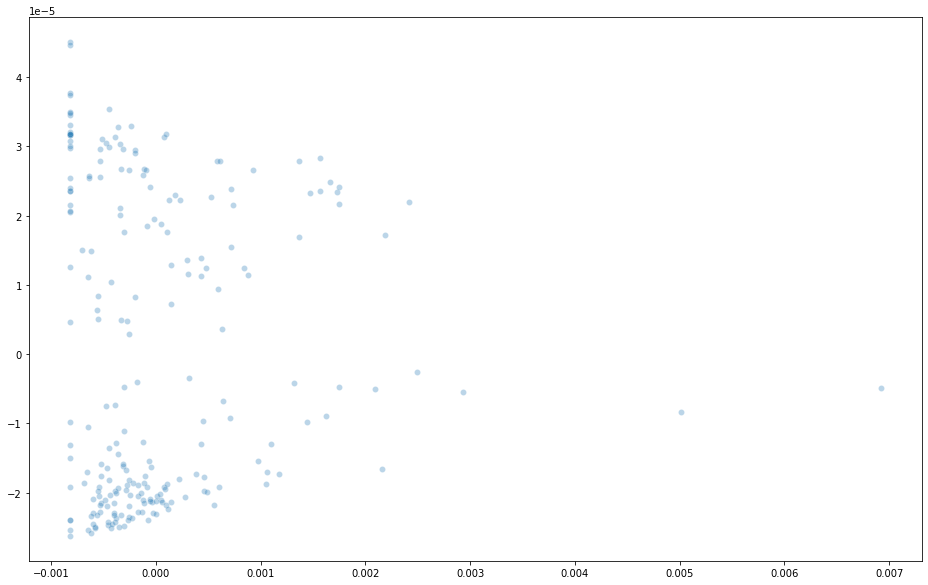

In [112]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(onlyPathwayEmbeddings)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  """Entry point for launching an IPython kernel.


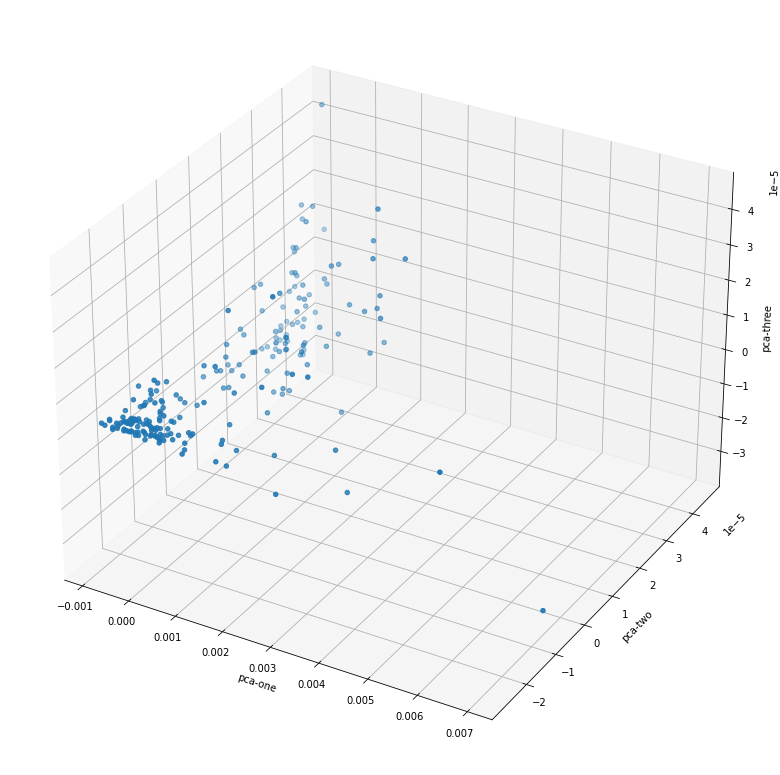

In [113]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()